In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [824]:
import glob
import statsmodels.api as sm
import statsmodels.formula.api as smf
from saturation.utils import *

import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.api import add_constant
from joblib import Parallel, delayed
import scipy.stats as stats
from scipy.stats import gaussian_kde
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import LogLocator, ScalarFormatter

In [768]:
def truncated_pareto_pdf(
    *,
    x: float,
    alpha: float,
    x_min: float,
    x_max: float,
):
    return (alpha * x_min**alpha) / (x**(alpha + 1) * (1 - (x_min/x_max)**alpha))
    

def truncated_pareto_cdf(x, alpha, x_min, x_max):
    cdf = np.zeros_like(x, dtype=float)
    mask = (x >= x_min) & (x <= x_max)
    cdf[mask] = (1 - (x_min / x[mask])**alpha) / (1 - (x_min / x_max)**alpha)
    cdf[x > x_max] = 1.0
    
    return cdf

In [48]:
n_cores = 28

spark = (SparkSession.builder
         .master(f"local[{n_cores}]")
         .appName("Saturation")
         .config("spark.sql.shuffle.partitions", "500")
         .config("spark.driver.memory", "40g")
         .config("spark.driver.maxResultSize", "8g")
         .getOrCreate())

25/01/21 17:24:51 WARN Utils: Your hostname, muninn resolves to a loopback address: 127.0.1.1; using 192.168.50.14 instead (on interface enp8s0)
25/01/21 17:24:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/21 17:24:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [195]:
base_path = "/data/saturation/thesis_run_20250108/"

colors = ["blue", "black", "r", "orange", "g"]
line_styles = ["-"]
font_size = 24
dpi = 400

configs_df = create_configs_df(
    read_configs(
        base_path,
        spark,
        completed_only=False
    )
)
configs_pdf = configs_df.toPandas()

configs_pdf = configs_pdf[~configs_pdf.simulation_id.isna()].copy()
configs_pdf["rim_erasure_exponent"] = configs_pdf.rim_erasure_method.apply(lambda x: x.get("exponent", -1))
configs_pdf["rim_erasure_radius_ratio"] = configs_pdf.rim_erasure_method.apply(lambda x: x.get("ratio", -1))

In [517]:
configs_dict = dict()
for config_file in glob.glob(f"{base_path}/config/config*.yaml"):
    configs_dict.update(read_config(Path(config_file))["run_configurations"])

# Visualizing $\beta_1$ for all simulations

In [51]:
# selected_simulation_ids = list(configs_pdf[configs_pdf.study_region_size == 1000].simulation_id.astype(int))
selected_simulation_ids = list(configs_pdf[(configs_pdf.study_region_size == 1000) & (configs_pdf.slope <= -3)].simulation_id.astype(int))

In [52]:
df = get_statistics_with_lifespans_for_simulations(
    selected_simulation_ids,
    base_path,
    configs_df,
    spark,
    n_samples_per_sim=100000
)
df

,x,y,radius,simulation_id,ntot,nobs,areal_density,slope,mrp,rmult,rim_erasure_method_name,rim_erasure_radius_ratio,rim_erasure_exponent,lifespan
0,139.554657,928.245911,3.416565,214,79,79,0.0,-4.2,0.5,1.0,NaN,2.0,1.0,4864437
1,486.786957,384.144104,3.590422,214,188,188,0.0,-4.2,0.5,1.0,NaN,2.0,1.0,15860758
2,215.888321,1123.321045,3.862679,214,249,249,0.0,-4.2,0.5,1.0,NaN,2.0,1.0,7354128
3,290.811188,843.766724,3.563076,214,696,693,0.0,-4.2,0.5,1.0,NaN,2.0,1.0,7736722
4,523.740723,165.581650,3.035205,214,856,850,0.0,-4.2,0.5,1.0,NaN,2.0,1.0,7542056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,153.179077,829.761169,3.824246,131,622150,1872,0.0,-4.0,0.5,1.0,NaN,2.0,0.6,2037248
99996,417.363525,648.522034,3.065876,131,622239,1877,0.0,-4.0,0.5,1.0,NaN,2.0,0.6,581337
99997,627.590210,894.933105,3.820706,131,622272,1885,0.0,-4.0,0.5,1.0,NaN,2.0,0.6,1558271
99998,951.341614,494.838715,3.195127,131,622295,1888,0.0,-4.0,0.5,1.0,NaN,2.0,0.6,1791223


In [ ]:
# Fit models for all simulations
models_by_sim_id = dict()

for simulation_id in df.simulation_id.drop_duplicates():
    d = df[df.simulation_id == simulation_id]

    # Fit a negative binomial model
    model = smf.negativebinomial(data=d, formula="lifespan ~ 1 + np.log(radius)").fit(maxiter=1000, method="bfgs", cov_type="HC0")
    models_by_sim_id[simulation_id] = model

In [ ]:
data_to_plot = configs_pdf[configs_pdf.simulation_id.isin(models_by_sim_id.keys())].copy()
data_to_plot["fitted_slope"] = [models_by_sim_id[simulation_id].params.iloc[1] for simulation_id in models_by_sim_id.keys()]
data_to_plot["fitted_slope_std_err"] = [models_by_sim_id[simulation_id].bse.iloc[1] for simulation_id in models_by_sim_id.keys()]

In [ ]:
fig = plt.figure(figsize=(12, 6), dpi=400)
ax = fig.add_subplot(111)

# Normalize color variable to range [0, 1] for the colormap
norm = plt.Normalize(data_to_plot["rim_erasure_exponent"].min(), data_to_plot["rim_erasure_exponent"].max())

for rim_erasure_exponent in data_to_plot.rim_erasure_exponent.drop_duplicates().sort_values():
    d = data_to_plot[data_to_plot.rim_erasure_exponent == rim_erasure_exponent].sort_values("slope").copy()
    ax.errorbar(
        d.slope,
        d.fitted_slope,
        d.fitted_slope_std_err,
        marker="+",
        color=cm.viridis(norm(rim_erasure_exponent)),
        ecolor=cm.viridis(norm(rim_erasure_exponent))
    )

sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])  # Required for colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("$\\tau$", fontsize=font_size)

ax.set_xlabel("$b$", fontsize=font_size)
ax.set_ylabel("$\\hat{\\beta_1}$", fontsize=font_size)

plt.savefig(f"figures/nb2_model_estimates_all_slopes.png", bbox_inches="tight")

In [ ]:
fig = plt.figure(figsize=(12, 6), dpi=400)
ax = fig.add_subplot(111)

# Normalize color variable to range [0, 1] for the colormap
norm = plt.Normalize(data_to_plot["rim_erasure_exponent"].min(), data_to_plot["rim_erasure_exponent"].max())

for rim_erasure_exponent in data_to_plot.rim_erasure_exponent.drop_duplicates().sort_values():
    d = data_to_plot[(data_to_plot.rim_erasure_exponent == rim_erasure_exponent) & (data_to_plot.slope > -2.5)].sort_values("slope").copy()
    ax.errorbar(
        d.slope,
        d.fitted_slope,
        d.fitted_slope_std_err,
        marker="+",
        color=cm.viridis(norm(rim_erasure_exponent)),
        ecolor=cm.viridis(norm(rim_erasure_exponent))
    )

sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])  # Required for colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("$\\tau$", fontsize=font_size)

ax.set_xlabel("$b$", fontsize=font_size)
ax.set_ylabel("$\\hat{\\beta_1}$", fontsize=font_size)

plt.savefig(f"figures/nb2_model_estimates_shallow_slopes.png", bbox_inches="tight")

# Comparing CSFD slope to predicted lifetime

In [826]:
min_slope = -5
max_slope = -3
max_simulation_id = 230

selected_simulation_ids = list(configs_pdf[
    (configs_pdf.study_region_size == 1000)
    & (configs_pdf.slope <= max_slope)
    & (configs_pdf.slope >= min_slope)
    & (configs_pdf.simulation_id <= max_simulation_id)
].simulation_id.astype(int))

model_data = get_statistics_with_lifespans_for_simulations(
    selected_simulation_ids,
    base_path,
    configs_df,
    spark,
    n_samples_per_sim=100000
)
model_data

,x,y,radius,simulation_id,ntot,nobs,areal_density,slope,mrp,rmult,rim_erasure_method_name,rim_erasure_radius_ratio,rim_erasure_exponent,lifespan
0,280.868500,1123.098999,3.958329,214,135,135,0.0,-4.2,0.5,1.0,NaN,2.0,1.0,16989867
1,871.312378,766.717285,5.102519,214,495,495,0.0,-4.2,0.5,1.0,NaN,2.0,1.0,22715498
2,311.118652,208.963074,7.041563,214,1005,991,0.0,-4.2,0.5,1.0,NaN,2.0,1.0,37780177
3,302.801025,279.834564,3.356862,214,1047,1032,0.0,-4.2,0.5,1.0,NaN,2.0,1.0,5592282
4,949.120178,627.643616,6.997251,214,1059,1044,0.0,-4.2,0.5,1.0,NaN,2.0,1.0,47262336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,504.131012,283.324249,3.329136,131,590360,1904,0.0,-4.0,0.5,1.0,NaN,2.0,0.6,2999815
99996,886.604248,1061.462280,3.254936,131,590363,1901,0.0,-4.0,0.5,1.0,NaN,2.0,0.6,2373916
99997,1116.701538,585.949951,4.880104,131,590384,1906,0.0,-4.0,0.5,1.0,NaN,2.0,0.6,6189433
99998,978.699768,472.626862,3.319604,131,590402,1900,0.0,-4.0,0.5,1.0,NaN,2.0,0.6,2413075


In [827]:
# Best model so far
model = smf.negativebinomial(data=model_data, formula="lifespan ~ 1 + slope:rim_erasure_exponent:np.log(radius) + rim_erasure_exponent:np.log(radius) + np.log(-slope) + slope").fit(maxiter=1000, method="BFGS", cov_type="HC0")

print(model.summary())
print(model.aic)

Optimization terminated successfully.
         Current function value: 15.180146
         Iterations: 30
         Function evaluations: 36
         Gradient evaluations: 36
                     NegativeBinomial Regression Results                      
Dep. Variable:               lifespan   No. Observations:             11000000
Model:               NegativeBinomial   Df Residuals:                 10999995
Method:                           MLE   Df Model:                            4
Date:                Thu, 23 Jan 2025   Pseudo R-squ.:                 0.06259
Time:                        20:05:40   Log-Likelihood:            -1.6698e+08
converged:                       True   LL-Null:                   -1.7813e+08
Covariance Type:                  HC0   LLR p-value:                     0.000
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [458]:
# # Model for b <= -2.5
# # Best model so far
# model = smf.negativebinomial(data=model_data, formula="lifespan ~ 1 + slope:rim_erasure_exponent:np.log(radius) + rim_erasure_exponent:np.log(radius) + np.log(-slope) + slope").fit(maxiter=1000, method="BFGS", cov_type="HC0")

# print(model.summary())
# print(model.aic)

Optimization terminated successfully.
         Current function value: 15.024169
         Iterations: 31
         Function evaluations: 36
         Gradient evaluations: 36
                     NegativeBinomial Regression Results                      
Dep. Variable:               lifespan   No. Observations:             13400000
Model:               NegativeBinomial   Df Residuals:                 13399995
Method:                           MLE   Df Model:                            4
Date:                Wed, 22 Jan 2025   Pseudo R-squ.:                 0.06234
Time:                        20:34:07   Log-Likelihood:            -2.0132e+08
converged:                       True   LL-Null:                   -2.1471e+08
Covariance Type:                  HC0   LLR p-value:                     0.000
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [828]:
target_ntot = int(1e6)

states = dict()
for simulation_id in selected_simulation_ids:
    state = get_states_at_ntots(
        simulation_id=simulation_id,
        configs_dict=configs_dict,
        base_path=base_path,
        target_ntots=[target_ntot],
        spark=spark
    )
    states[simulation_id] = state[target_ntot]

In [829]:
slope_estimates = dict()
for simulation_id, state in states.items():
    slope_estimates[simulation_id] = estimate_slopes_for_states({simulation_id: state}, configs_dict[simulation_id]["r_stat"])

In [830]:
first_sim_id = list(slope_estimates.keys())[0]
d = configs_dict[first_sim_id]
r_min = d["r_stat"]
r_max = d["r_max"] // 2

r_dist_min = configs_dict[first_sim_id]["r_min"]
r_dist_max = d["r_max"]

df = None
for simulation_id, estimates in slope_estimates.items():
    d = configs_dict[simulation_id]
    
    state = states[simulation_id].sort_values("radius").copy()
    state["simulation_id"] = simulation_id
    state["slope"] = d["slope"]
    state["rim_erasure_exponent"] = d["rim_erasure_method"]["exponent"]
    state["obs_n_gte_r"] = range(len(state.radius) + 1, 1, -1)
    state["mle_estimated_slope"] = estimates.iloc[0].alpha
    state["mle_estimated_slope_sigma"] = estimates.iloc[0].sigma
    state["n_obs"] = state.shape[0]
    state["predicted_kappa"] = model.predict(state)
    
    state["production_function"] = truncated_pareto_pdf(
        x=state.radius,
        alpha=-state.slope,
        x_min=r_dist_min,
        x_max=r_dist_max,
    )
    state["predicted_n_obs"] = state.production_function * state.predicted_kappa

    # To calculate the "integral", we have to back out the predicted slope, multiply by the radius, and divide by 1 - predicted slope
    state["predicted_slope"] = state.slope + (mp["slope:rim_erasure_exponent:np.log(radius)"] * state.slope * state.rim_erasure_exponent + mp["rim_erasure_exponent:np.log(radius)"] * state.rim_erasure_exponent)
    state["divisor"] = (1 - state.predicted_slope)
    state["predicted_n_gte_r"] = state.predicted_n_obs * state.radius / state.divisor

    state["residual"] = state.obs_n_gte_r / state.predicted_n_gte_r
    
    state["mle_estimated_n_gt_r"] = state.radius**state.mle_estimated_slope
    state["mle_estimated_n_gt_r"] = state.mle_estimated_n_gt_r / state.mle_estimated_n_gt_r.max() * state.n_obs
    df = state if df is None else pd.concat([df, state], axis=0)

In [831]:
# Filter some outliers for clarity
alpha_ci = 0.0001
d = df[(df.residual < df.residual.quantile(1 - alpha_ci)) & (df.residual > df.residual.quantile(alpha_ci))]

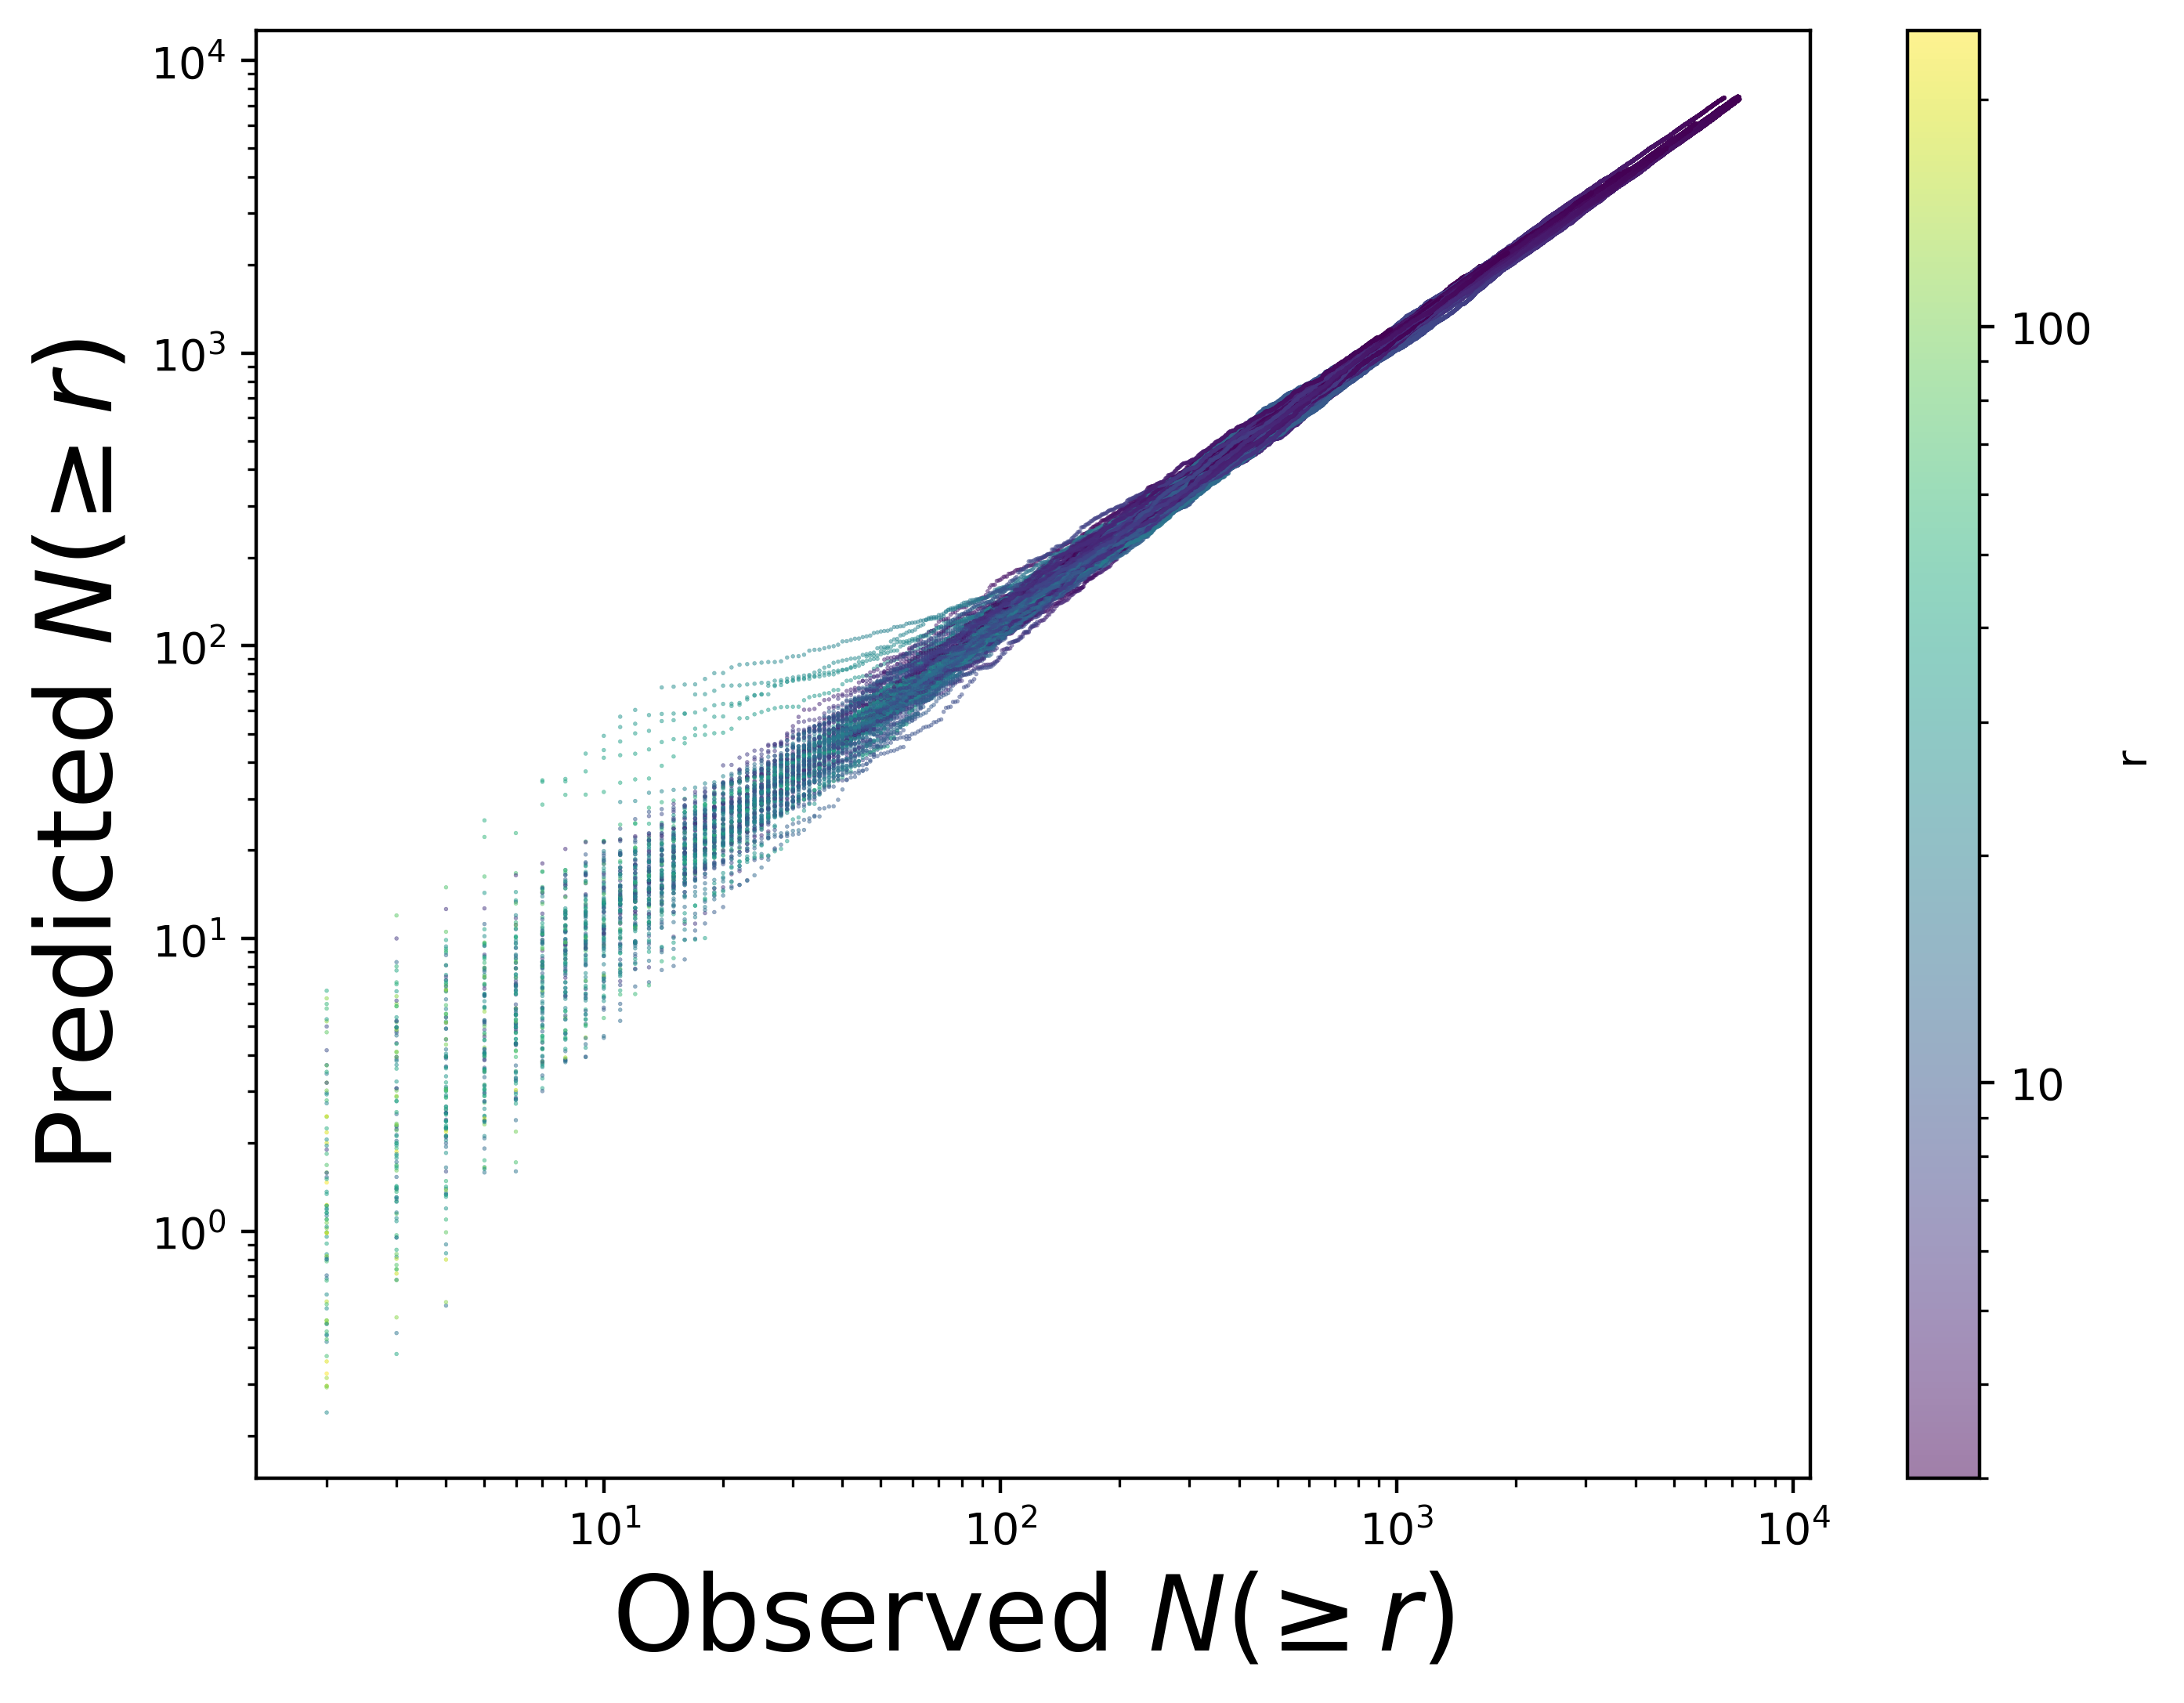

In [832]:
fig = plt.figure(figsize=(8, 6), dpi=dpi)
ax = fig.add_subplot(111)

color_var = d.radius
scatter = ax.scatter(
    d.obs_n_gte_r,
    d.predicted_n_gte_r,
    c=color_var,
    s=0.75,
    norm=LogNorm(vmin=3, vmax=color_var.max()),
    cmap="viridis",
    alpha=0.5,
    linewidth=0.1
)

ax.set_xlabel("Observed $N(\\!\\geq r)$", fontsize=font_size)
ax.set_ylabel("Predicted $N(\\!\\geq r)$", fontsize=font_size)

cbar = fig.colorbar(scatter, ax=ax, label="r")
cbar.ax.tick_params(labelsize=10)

cbar.locator = LogLocator(base=10.0, numticks=10)
cbar.formatter = ScalarFormatter()
cbar.update_ticks()

ax.set_xscale('log')
ax.set_yscale('log')

plt.show()
# fig.savefig(f"figures/{scenario_name}_observed_vs_predicted_csfd.png", bbox_inches="tight")

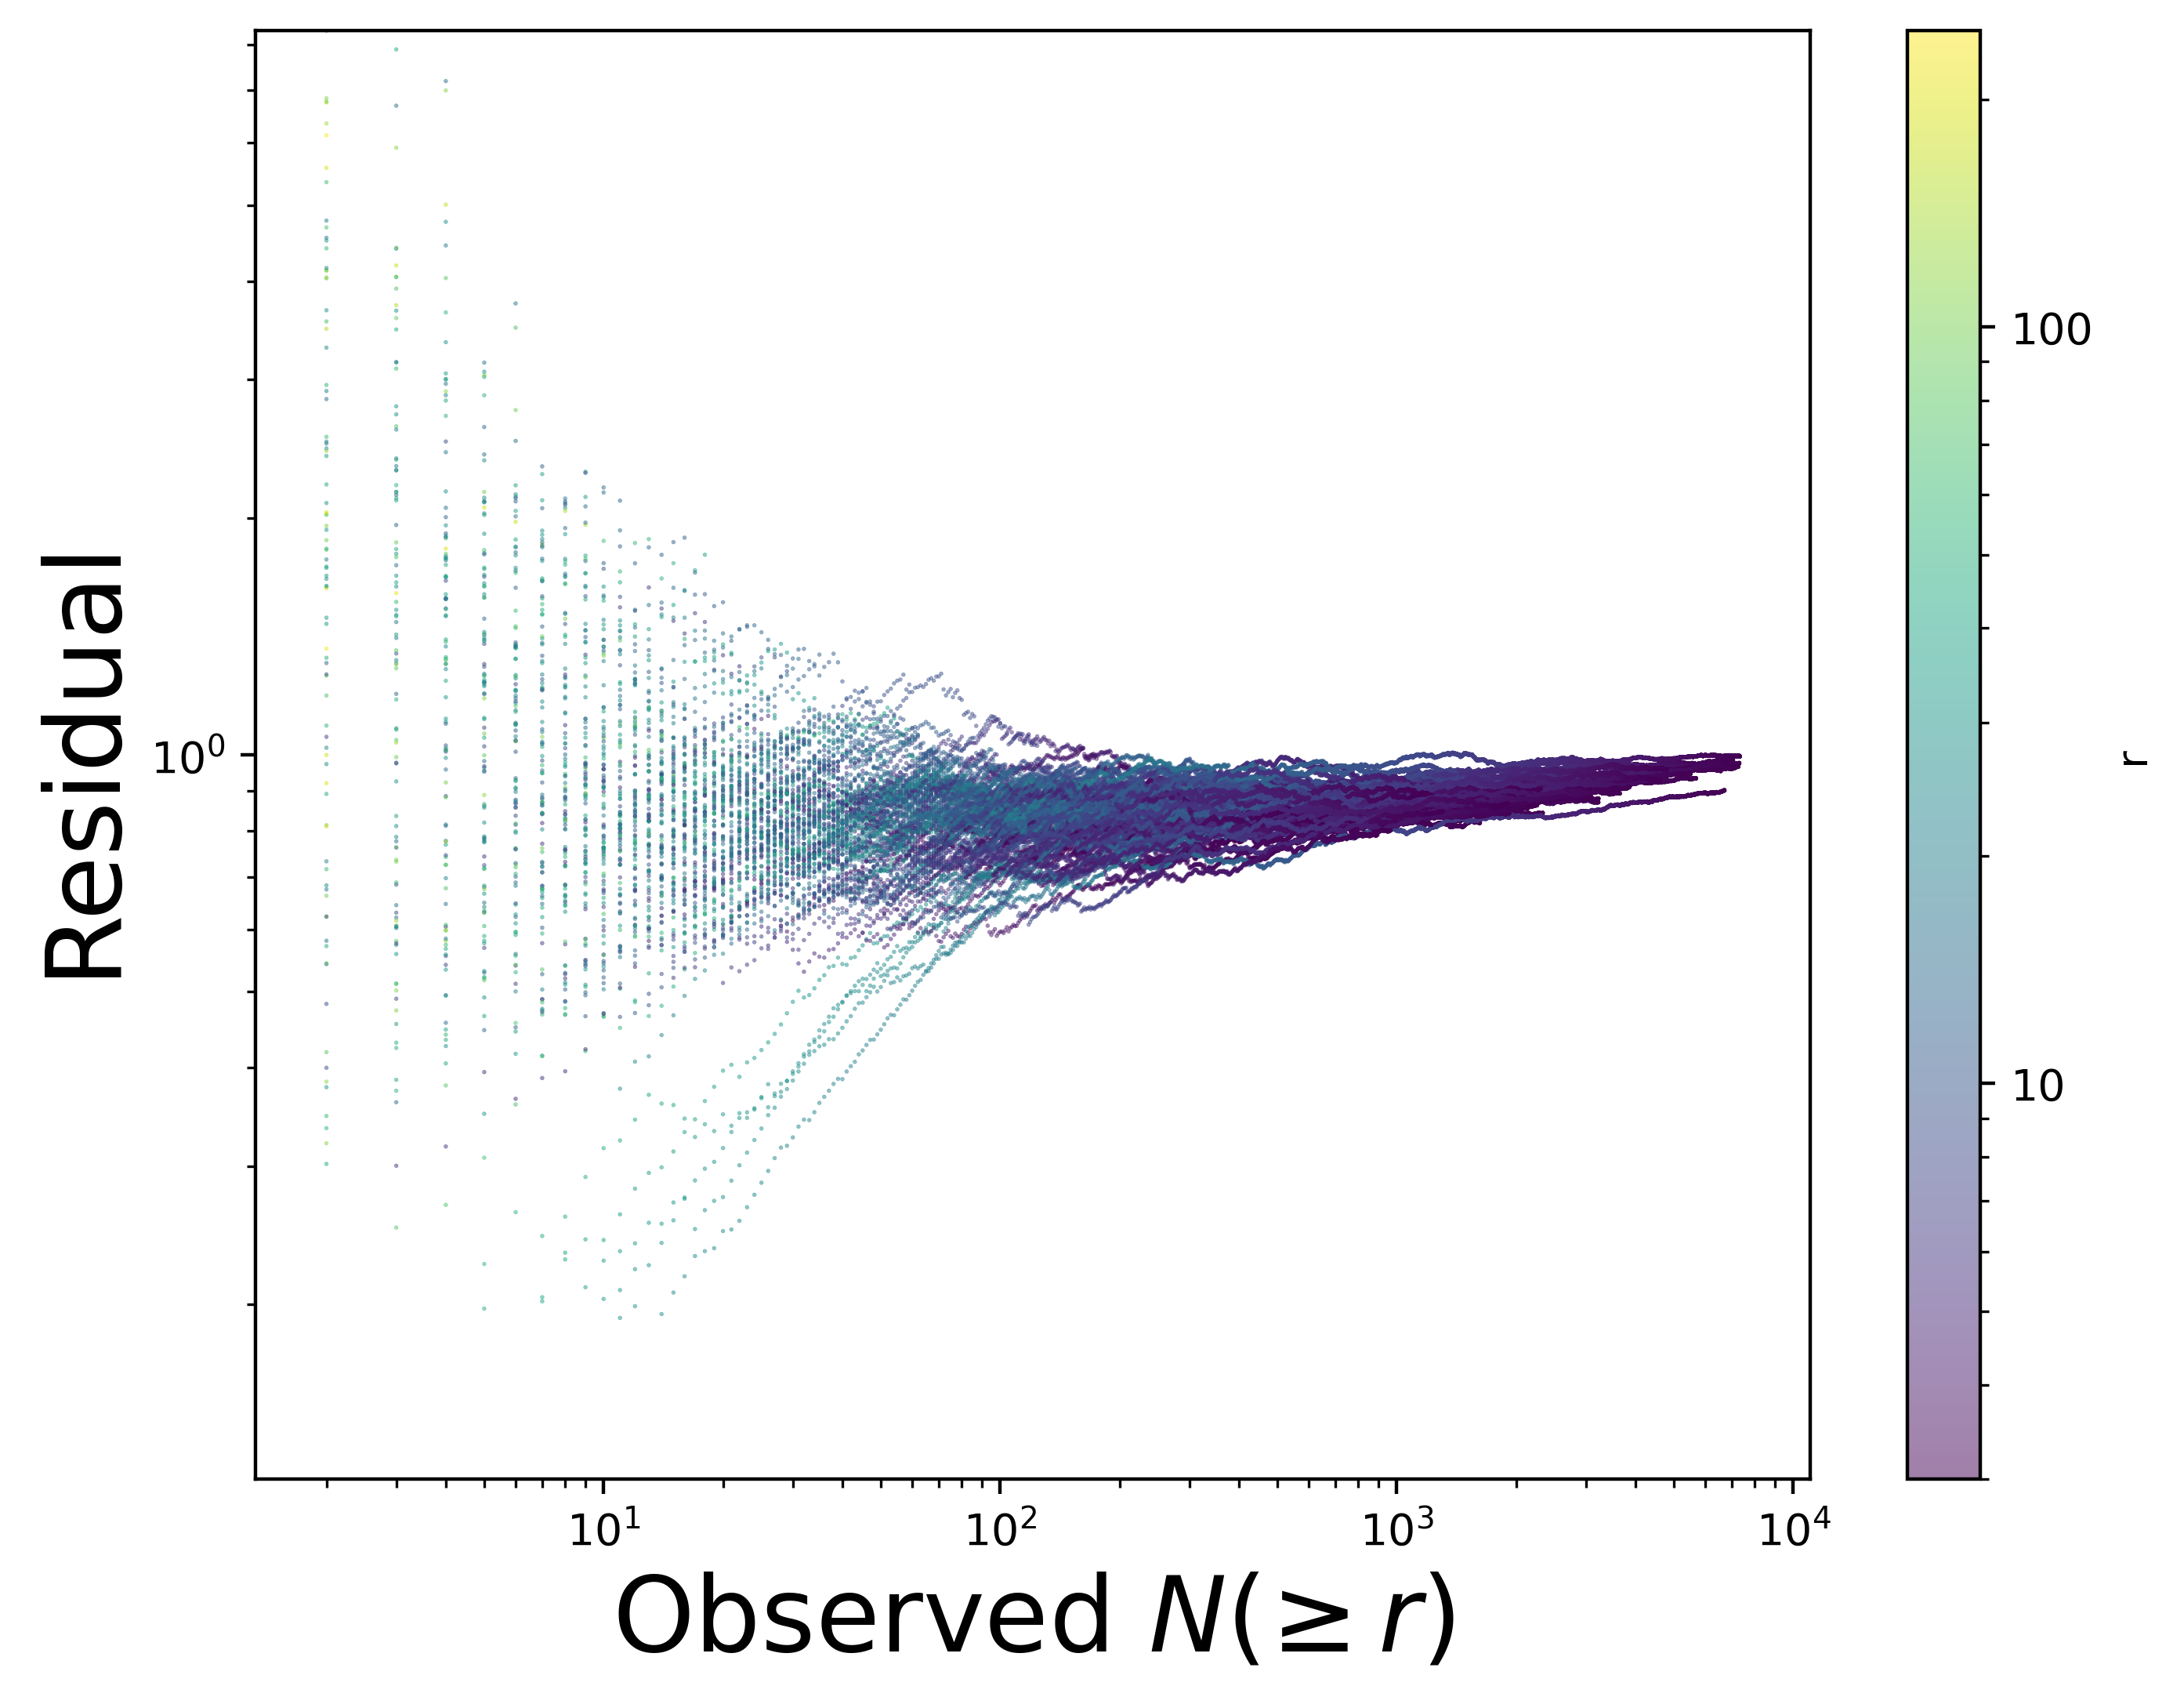

In [833]:
fig = plt.figure(figsize=(8, 6), dpi=dpi)
ax = fig.add_subplot(111)

color_var = d.radius
scatter = ax.scatter(
    d.obs_n_gte_r,
    d.residual,
    c=color_var,
    s=0.75,
    norm=LogNorm(vmin=3, vmax=color_var.max()),
    cmap="viridis",
    alpha=0.5,
    linewidth=0.1
)

ax.set_xlabel("Observed $N(\\!\\geq r)$", fontsize=font_size)
ax.set_ylabel("Residual", fontsize=font_size)

cbar = fig.colorbar(scatter, ax=ax, label="r")
cbar.ax.tick_params(labelsize=10)

cbar.locator = LogLocator(base=10.0, numticks=10)
cbar.formatter = ScalarFormatter()
cbar.update_ticks()

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylim([1/d.residual.abs().max(), d.residual.abs().max()])

plt.show()
# fig.savefig(f"figures/{scenario_name}_observed_vs_predicted_csfd.png", bbox_inches="tight")

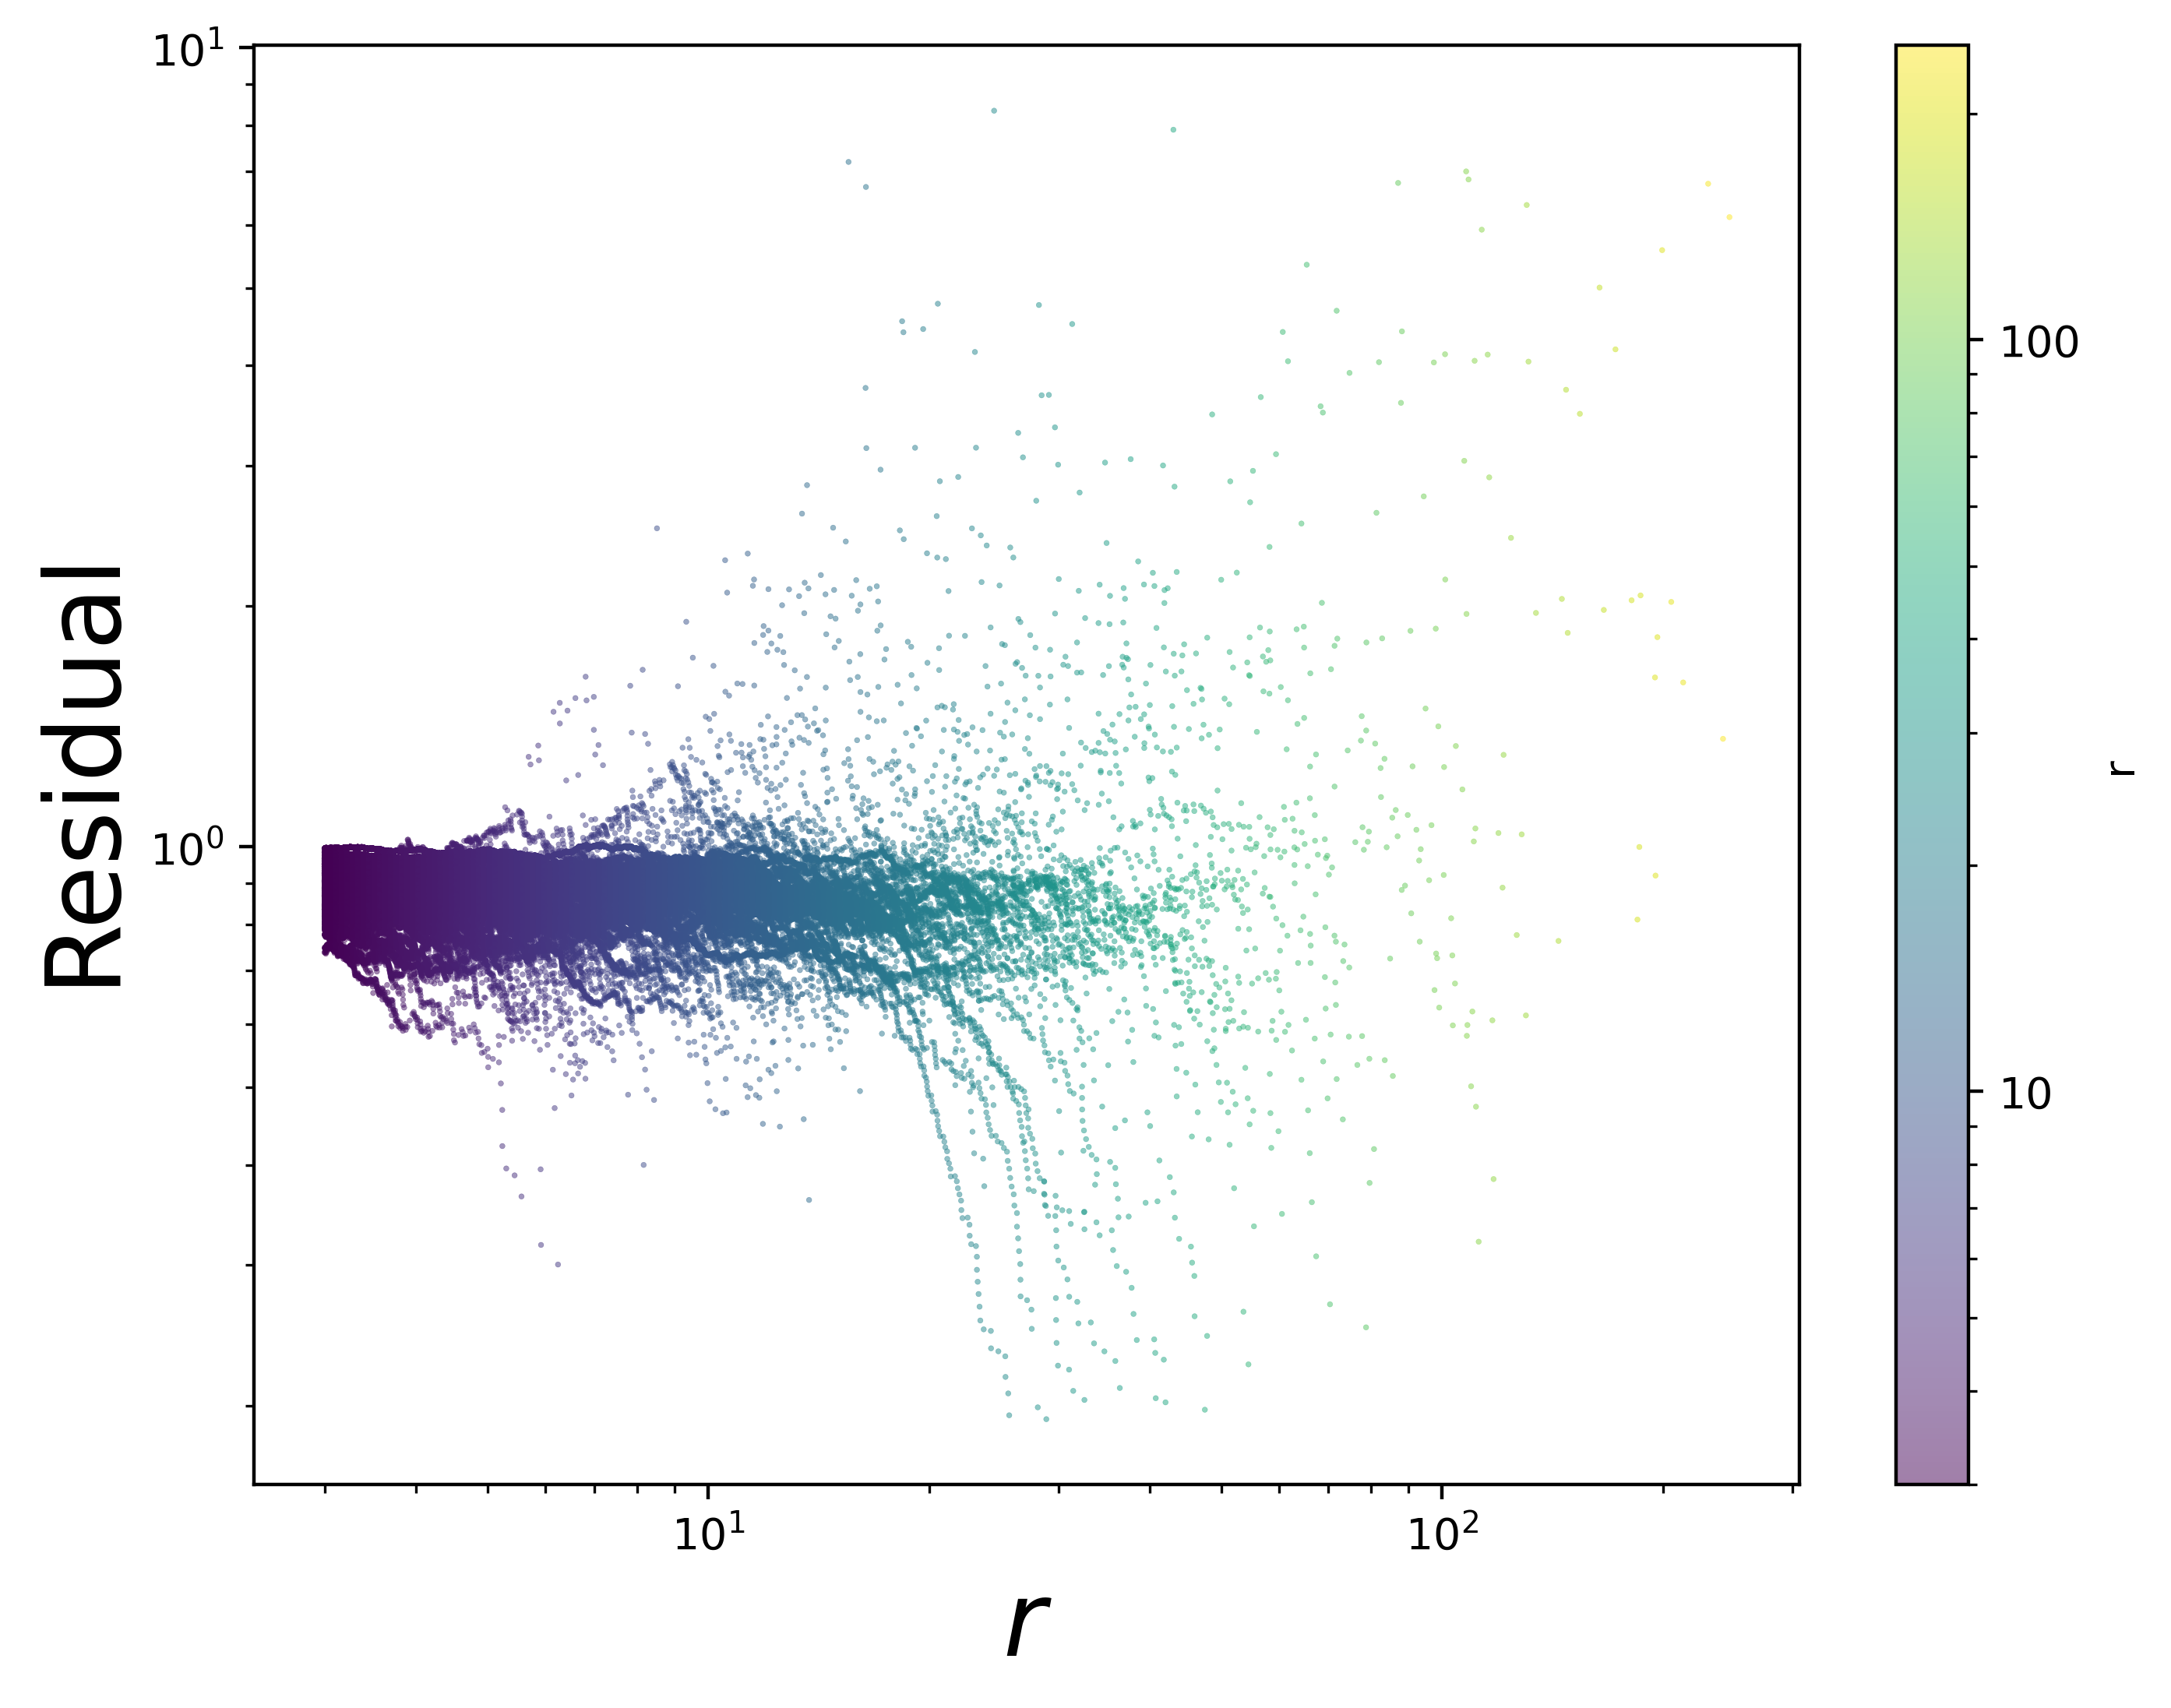

In [834]:
fig = plt.figure(figsize=(8, 6), dpi=dpi)
ax = fig.add_subplot(111)

color_var = d.radius
scatter = ax.scatter(
    d.radius,
    d.residual,
    c=color_var,
    s=1.5,
    norm=LogNorm(vmin=3, vmax=color_var.max()),
    cmap="viridis",
    alpha=0.5,
    linewidth=0.1
)

ax.set_xlabel("$r$", fontsize=font_size)
ax.set_ylabel("Residual", fontsize=font_size)

cbar = fig.colorbar(scatter, ax=ax, label="r")
cbar.ax.tick_params(labelsize=10)

cbar.locator = LogLocator(base=10.0, numticks=10)
cbar.formatter = ScalarFormatter()
cbar.update_ticks()

ax.set_xscale('log')
ax.set_yscale('log')

plt.show()
# fig.savefig(f"figures/{scenario_name}_observed_vs_predicted_csfd.png", bbox_inches="tight")

In [304]:
# 3d scatter reference if needed
# fig = px.scatter_3d(
#     data, 
#     x="slope", 
#     y="rim_erasure_exponent", 
#     z="residual", 
#     color="estimated_n_obs_from_kappa",
#     color_continuous_scale="Viridis",
# )

# fig.update_traces(marker=dict(size=2)) 

# fig.update_layout(
#     height=800,
#     width=1200,
# )

# fig.show()

# Compare the analytical model to out-of-sample observed CSFDs

In [892]:
scenario_name = "out_of_sample"
selected_simulation_id = 154
selected_config = configs_dict[selected_simulation_id]

slope = selected_config["slope"]
rim_erasure_exponent = selected_config["rim_erasure_method"]["exponent"]
ntot = selected_config["stop_condition"]["ntot"]
r_min = selected_config["r_min"]

state = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    target_ntots=[selected_ntot],
    spark=spark
)[selected_ntot]

state = state.sort_values("radius")
mle_estimated_slope, ml_estimated_slope_sigma = estimate_slopes_for_states({simulation_id: state}, configs_dict[simulation_id]["r_stat"])[["alpha", "sigma"]].loc[0]
selected_config

{'calculate_areal_density': False,
 'calculate_nearest_neighbor_stats': False,
 'initial_rim_calculation_method': {'name': 'circumference'},
 'mrp': 0.5,
 'r_max': 250,
 'r_min': 0.55,
 'r_stat': 3,
 'random_seed': 2178425966,
 'rim_erasure_method': {'exponent': 0.7, 'name': 'exponent', 'ratio': 2.0},
 'rmult': 1.0,
 'slope': -3.6,
 'spatial_hash_cell_size': 5,
 'stop_condition': {'name': 'ntot', 'ntot': 1000000},
 'study_region_padding': 125,
 'study_region_size': 1000,
 'write_crater_removals_cadence': 50000,
 'write_craters_cadence': 50000,
 'write_image_cadence': 0,
 'write_image_points': [],
 'write_state_cadence': 0,
 'write_statistics_cadence': 50000}

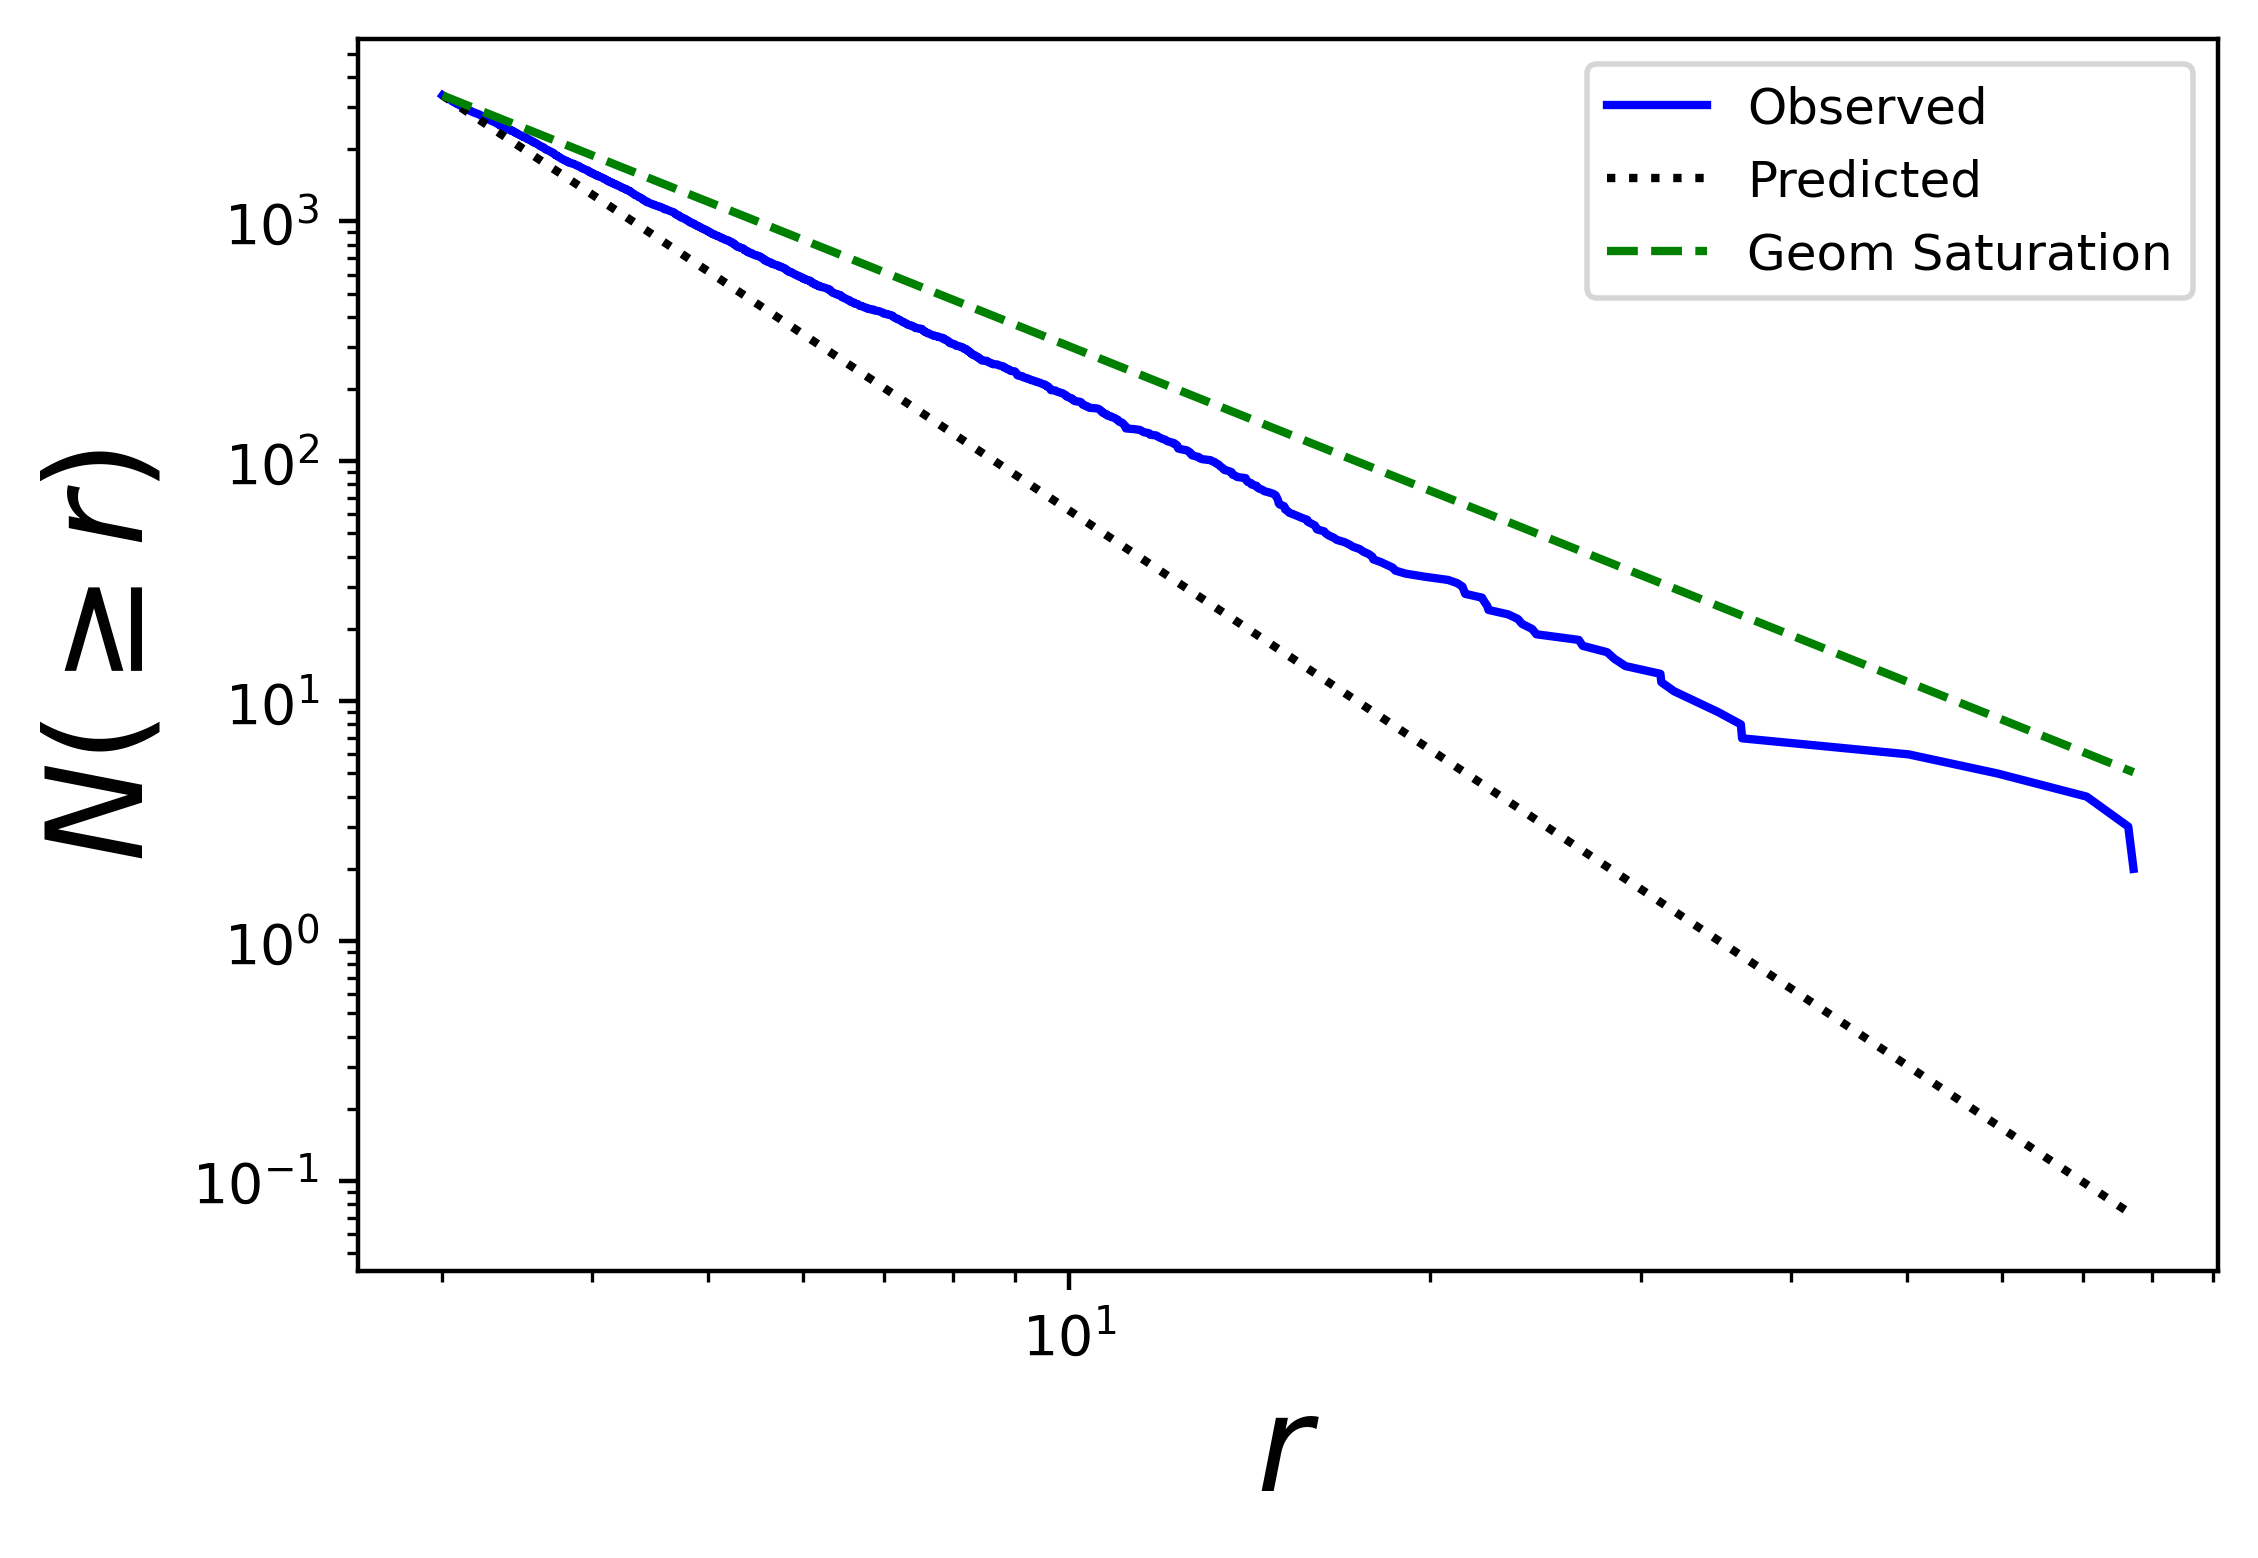

In [893]:
fig = plt.figure(figsize=(6, 4), dpi=dpi)
ax = fig.add_subplot(111)

ax.plot(state.radius, range(len(state.radius) + 1, 1, -1), label="Observed", c="blue")

production_function = state.radius ** slope

state["slope"] = slope
state["rim_erasure_exponent"] = rim_erasure_exponent
state["kappa_predicted"] = model.predict(state)

state["analytical_model_prediction"] = production_function * state.kappa_predicted
state["analytical_model_prediction"] = state.analytical_model_prediction / state.analytical_model_prediction.max() * state.shape[0]
ax.plot(
    state.radius,
    state.analytical_model_prediction,
    ls="dotted",
    c="black",
    label="Predicted"
)

state["geometric_saturation_prediction"] = state.radius**-2
state["geometric_saturation_prediction"] = state.geometric_saturation_prediction / state.geometric_saturation_prediction.max() * state.shape[0]
ax.plot(
    state.radius,
    state.geometric_saturation_prediction,
    ls="dashed",
    c="green",
    label="Geom Saturation"
)

ax.set_xlabel("$r$", fontsize=font_size)
ax.set_ylabel("$N(\\geq r)$", fontsize=font_size)

ax.legend(fontsize=9)
ax.set_xscale('log')
ax.set_yscale('log')

plt.show()
fig.savefig(f"figures/{scenario_name}_observed_vs_predicted_csfd.png", bbox_inches="tight")

In [894]:
mp = model.params
predicted_slope = slope + (mp["slope:rim_erasure_exponent:np.log(radius)"] * slope * rim_erasure_exponent + mp["rim_erasure_exponent:np.log(radius)"] * rim_erasure_exponent)

print(f"MLE estimated slope: {mle_estimated_slope:.3f}, sigma: {ml_estimated_slope_sigma:.3f}")
print(f"Predicted slope: {predicted_slope:.3f}")

MLE estimated slope: -2.508, sigma: 0.044
Predicted slope: -3.310


In [895]:
predicted_slope = slope + (mp["slope:rim_erasure_exponent:np.log(radius)"] * slope * rim_erasure_exponent + mp["rim_erasure_exponent:np.log(radius)"] * rim_erasure_exponent)
hypothetical_cdf = lambda x: truncated_pareto_cdf(x, -predicted_slope, selected_config["r_stat"], r_dist_max)
ks_stat, p_value = stats.kstest(state.radius, hypothetical_cdf)

print(f"KS Statistic: {ks_stat}")
print(f"P-value: {p_value}")

KS Statistic: 0.09580984527220104
P-value: 3.546874687216999e-27


# Hypothesis test for steep-sloped CSFDs (b <= -3)

In [979]:
target_ntot = int(1e6)

min_slope = -5
max_slope = -3
max_simulation_id = 230

selected_simulation_ids = list(configs_pdf[
    (configs_pdf.study_region_size == 1000)
    & (configs_pdf.slope <= max_slope)
    & (configs_pdf.slope >= min_slope)
    & (configs_pdf.simulation_id <= max_simulation_id)
].simulation_id.astype(int))

model_data = get_statistics_with_lifespans_for_simulations(
    selected_simulation_ids,
    base_path,
    configs_df,
    spark,
    n_samples_per_sim=500000
)
model_data

,x,y,radius,simulation_id,ntot,nobs,areal_density,slope,mrp,rmult,rim_erasure_method_name,rim_erasure_radius_ratio,rim_erasure_exponent,lifespan
0,430.050934,597.817871,4.542943,214,7,7,0.0,-4.2,0.5,1.0,NaN,2.0,1.0,20512438
1,566.268250,785.857361,4.966136,214,30,30,0.0,-4.2,0.5,1.0,NaN,2.0,1.0,7850151
2,950.077942,404.015228,3.100740,214,74,74,0.0,-4.2,0.5,1.0,NaN,2.0,1.0,3332841
3,139.554657,928.245911,3.416565,214,79,79,0.0,-4.2,0.5,1.0,NaN,2.0,1.0,4864437
4,172.364334,449.977234,3.035970,214,110,110,0.0,-4.2,0.5,1.0,NaN,2.0,1.0,4398002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,728.249207,1079.854492,3.344935,131,554529,1899,0.0,-4.0,0.5,1.0,NaN,2.0,0.6,3168882
499996,1051.573853,377.795166,3.306993,131,554546,1900,0.0,-4.0,0.5,1.0,NaN,2.0,0.6,1664199
499997,527.165466,700.623169,3.575651,131,554645,1881,0.0,-4.0,0.5,1.0,NaN,2.0,0.6,2218589
499998,728.073792,950.144165,4.474452,131,554646,1881,0.0,-4.0,0.5,1.0,NaN,2.0,0.6,5291404


In [980]:
model = smf.negativebinomial(data=model_data, formula="lifespan ~ 1 + slope:rim_erasure_exponent:np.log(radius) + rim_erasure_exponent:np.log(radius) + np.log(-slope) + slope").fit(maxiter=1000, method="BFGS", cov_type="HC0")

print(model.summary())
print(model.aic)

Optimization terminated successfully.
         Current function value: 15.179779
         Iterations: 34
         Function evaluations: 39
         Gradient evaluations: 39
                     NegativeBinomial Regression Results                      
Dep. Variable:               lifespan   No. Observations:             55000000
Model:               NegativeBinomial   Df Residuals:                 54999995
Method:                           MLE   Df Model:                            4
Date:                Thu, 23 Jan 2025   Pseudo R-squ.:                 0.06259
Time:                        23:33:23   Log-Likelihood:            -8.3489e+08
converged:                       True   LL-Null:                   -8.9064e+08
Covariance Type:                  HC0   LLR p-value:                     0.000
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [981]:
d = configs_dict[selected_simulation_ids[0]]
r_stat = d["r_stat"]
r_dist_min = d["r_min"]
r_dist_max = d["r_max"]

mp = model.params

df = None
for simulation_id in selected_simulation_ids:
    config = configs_dict[simulation_id]
    
    state = get_states_at_ntots(
        simulation_id=simulation_id,
        configs_dict=configs_dict,
        base_path=base_path,
        target_ntots=[target_ntot],
        spark=spark
    )[target_ntot]

    slope = config["slope"]
    rim_erasure_exponent = config["rim_erasure_method"]["exponent"]
    
    state["simulation_id"] = simulation_id
    state["slope"] = slope
    state["rim_erasure_exponent"] = rim_erasure_exponent

    predicted_slope = slope + (mp["slope:rim_erasure_exponent:np.log(radius)"] * slope * rim_erasure_exponent + mp["rim_erasure_exponent:np.log(radius)"] * rim_erasure_exponent)
    hypothetical_cdf = lambda x: truncated_pareto_cdf(x, -predicted_slope, r_stat, r_dist_max)
    ks_statistic, p_value = stats.kstest(state.radius, hypothetical_cdf)

    state["predicted_slope"] = predicted_slope
    state["ks_statistic"] = ks_statistic
    state["ks_p_value"] = p_value

    df = state if df is None else pd.concat([df, state], axis=0)

In [982]:
columns = [
    "simulation_id",
    "slope",
    "rim_erasure_exponent",
    "predicted_slope",
    "ks_statistic",
    "ks_p_value",
]
hypothesis_test_results = df[columns].drop_duplicates()

In [983]:
# How many hypothesis tests were significant?
(hypothesis_test_results.ks_p_value < 0.01).mean()

0.06363636363636363

In [984]:
comparison_value = (hypothesis_test_results.ks_p_value < 0.01)
print(stats.pearsonr(comparison_value, hypothesis_test_results.rim_erasure_exponent))
print(stats.pearsonr(comparison_value, hypothesis_test_results.slope))
print(stats.pearsonr(comparison_value, hypothesis_test_results.slope * hypothesis_test_results.rim_erasure_exponent))

PearsonRResult(statistic=0.23987065540482244, pvalue=0.011602486581444782)
PearsonRResult(statistic=0.09421549943014162, pvalue=0.32756400956958936)
PearsonRResult(statistic=-0.189571087276586, pvalue=0.0473059469761749)


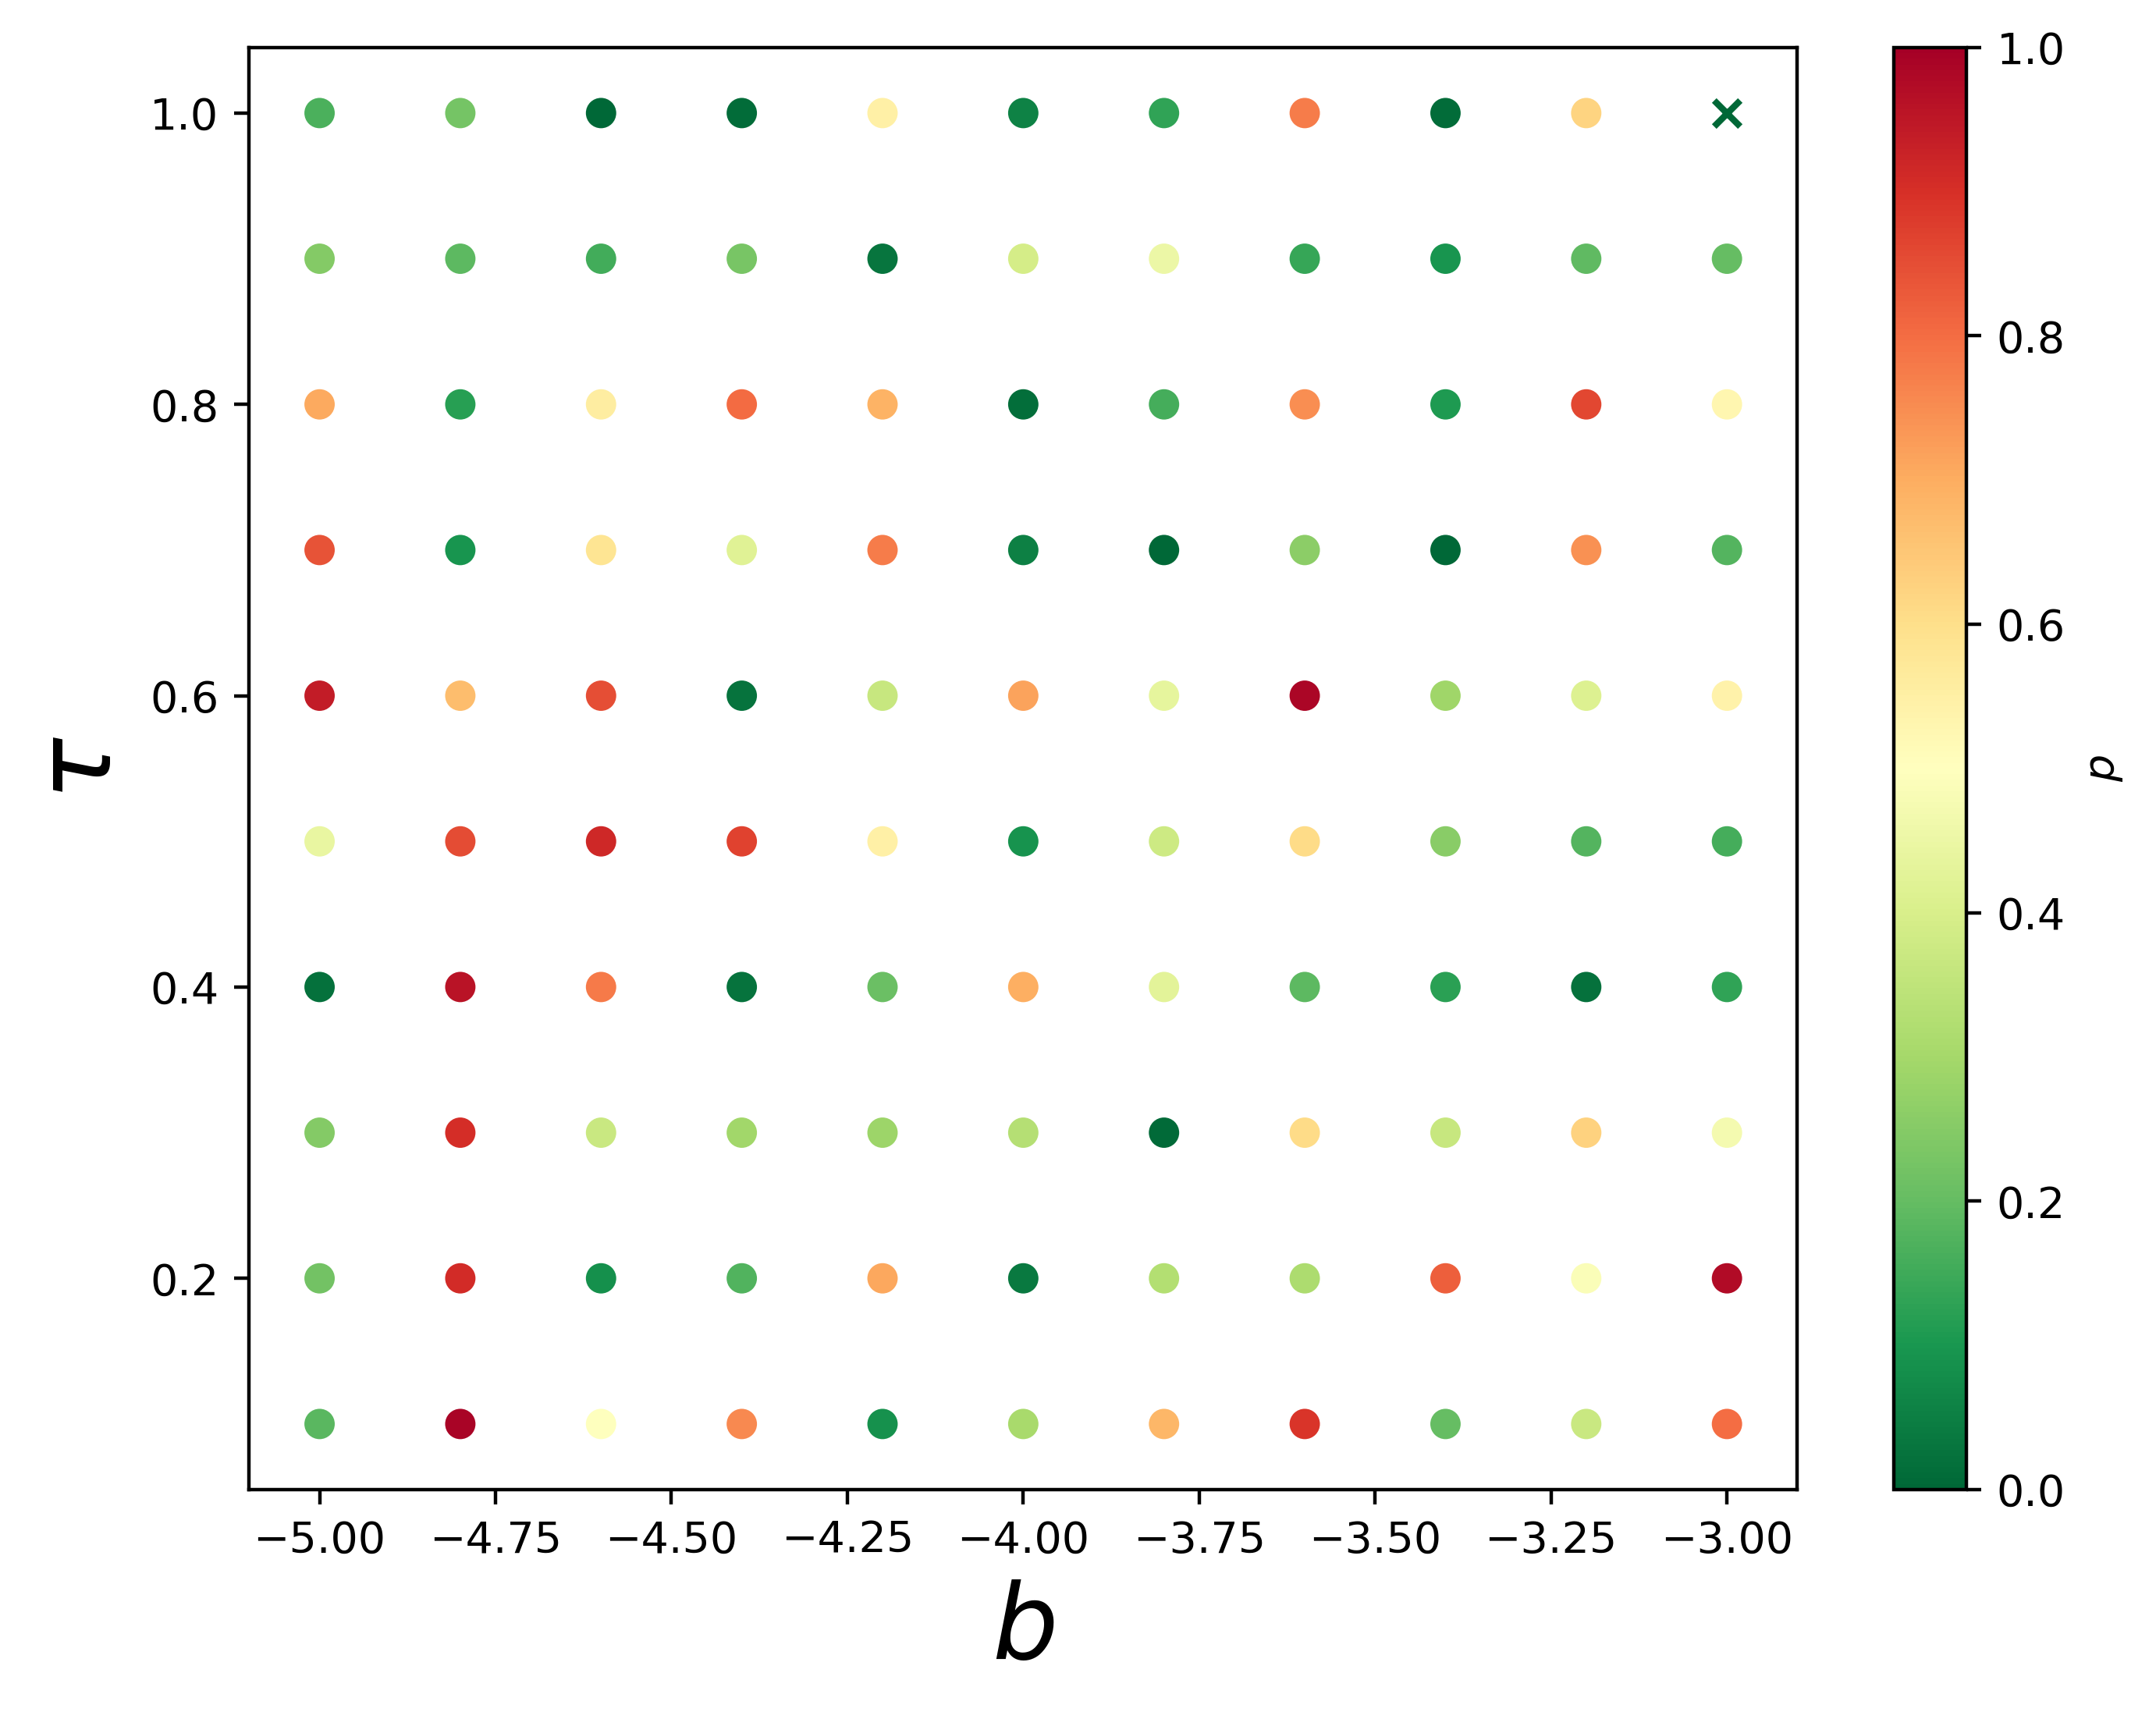

In [987]:
significance_level = 0.05 / hypothesis_test_results.shape[0]

fig = plt.figure(figsize=(8, 6), dpi=dpi)
ax = fig.add_subplot(111)

norm = Normalize(vmin=0.0, vmax=1.0) 

subset = hypothesis_test_results[hypothesis_test_results.ks_p_value < significance_level]
color_var = subset.ks_p_value
scatter = ax.scatter(
    subset.slope,
    subset.rim_erasure_exponent,
    marker="x",
    c=color_var,
    norm=norm,
    cmap="RdYlGn_r"
)

subset = hypothesis_test_results[hypothesis_test_results.ks_p_value >= significance_level]
color_var = subset.ks_p_value
scatter = ax.scatter(
    subset.slope,
    subset.rim_erasure_exponent,
    marker="o",
    c=color_var,
    norm=norm,
    cmap="RdYlGn_r"
)

ax.set_xlabel("$b$", fontsize=font_size)
ax.set_ylabel("$\\tau$", fontsize=font_size)

cbar = fig.colorbar(scatter, ax=ax, label="$p$")
cbar.ax.tick_params(labelsize=10)
cbar.update_ticks()

plt.show()
# fig.savefig(f"figures/{scenario_name}_observed_vs_predicted_csfd.png", bbox_inches="tight")

AttributeError: 'DataFrame' object has no attribute 'obs_n_gte_r'

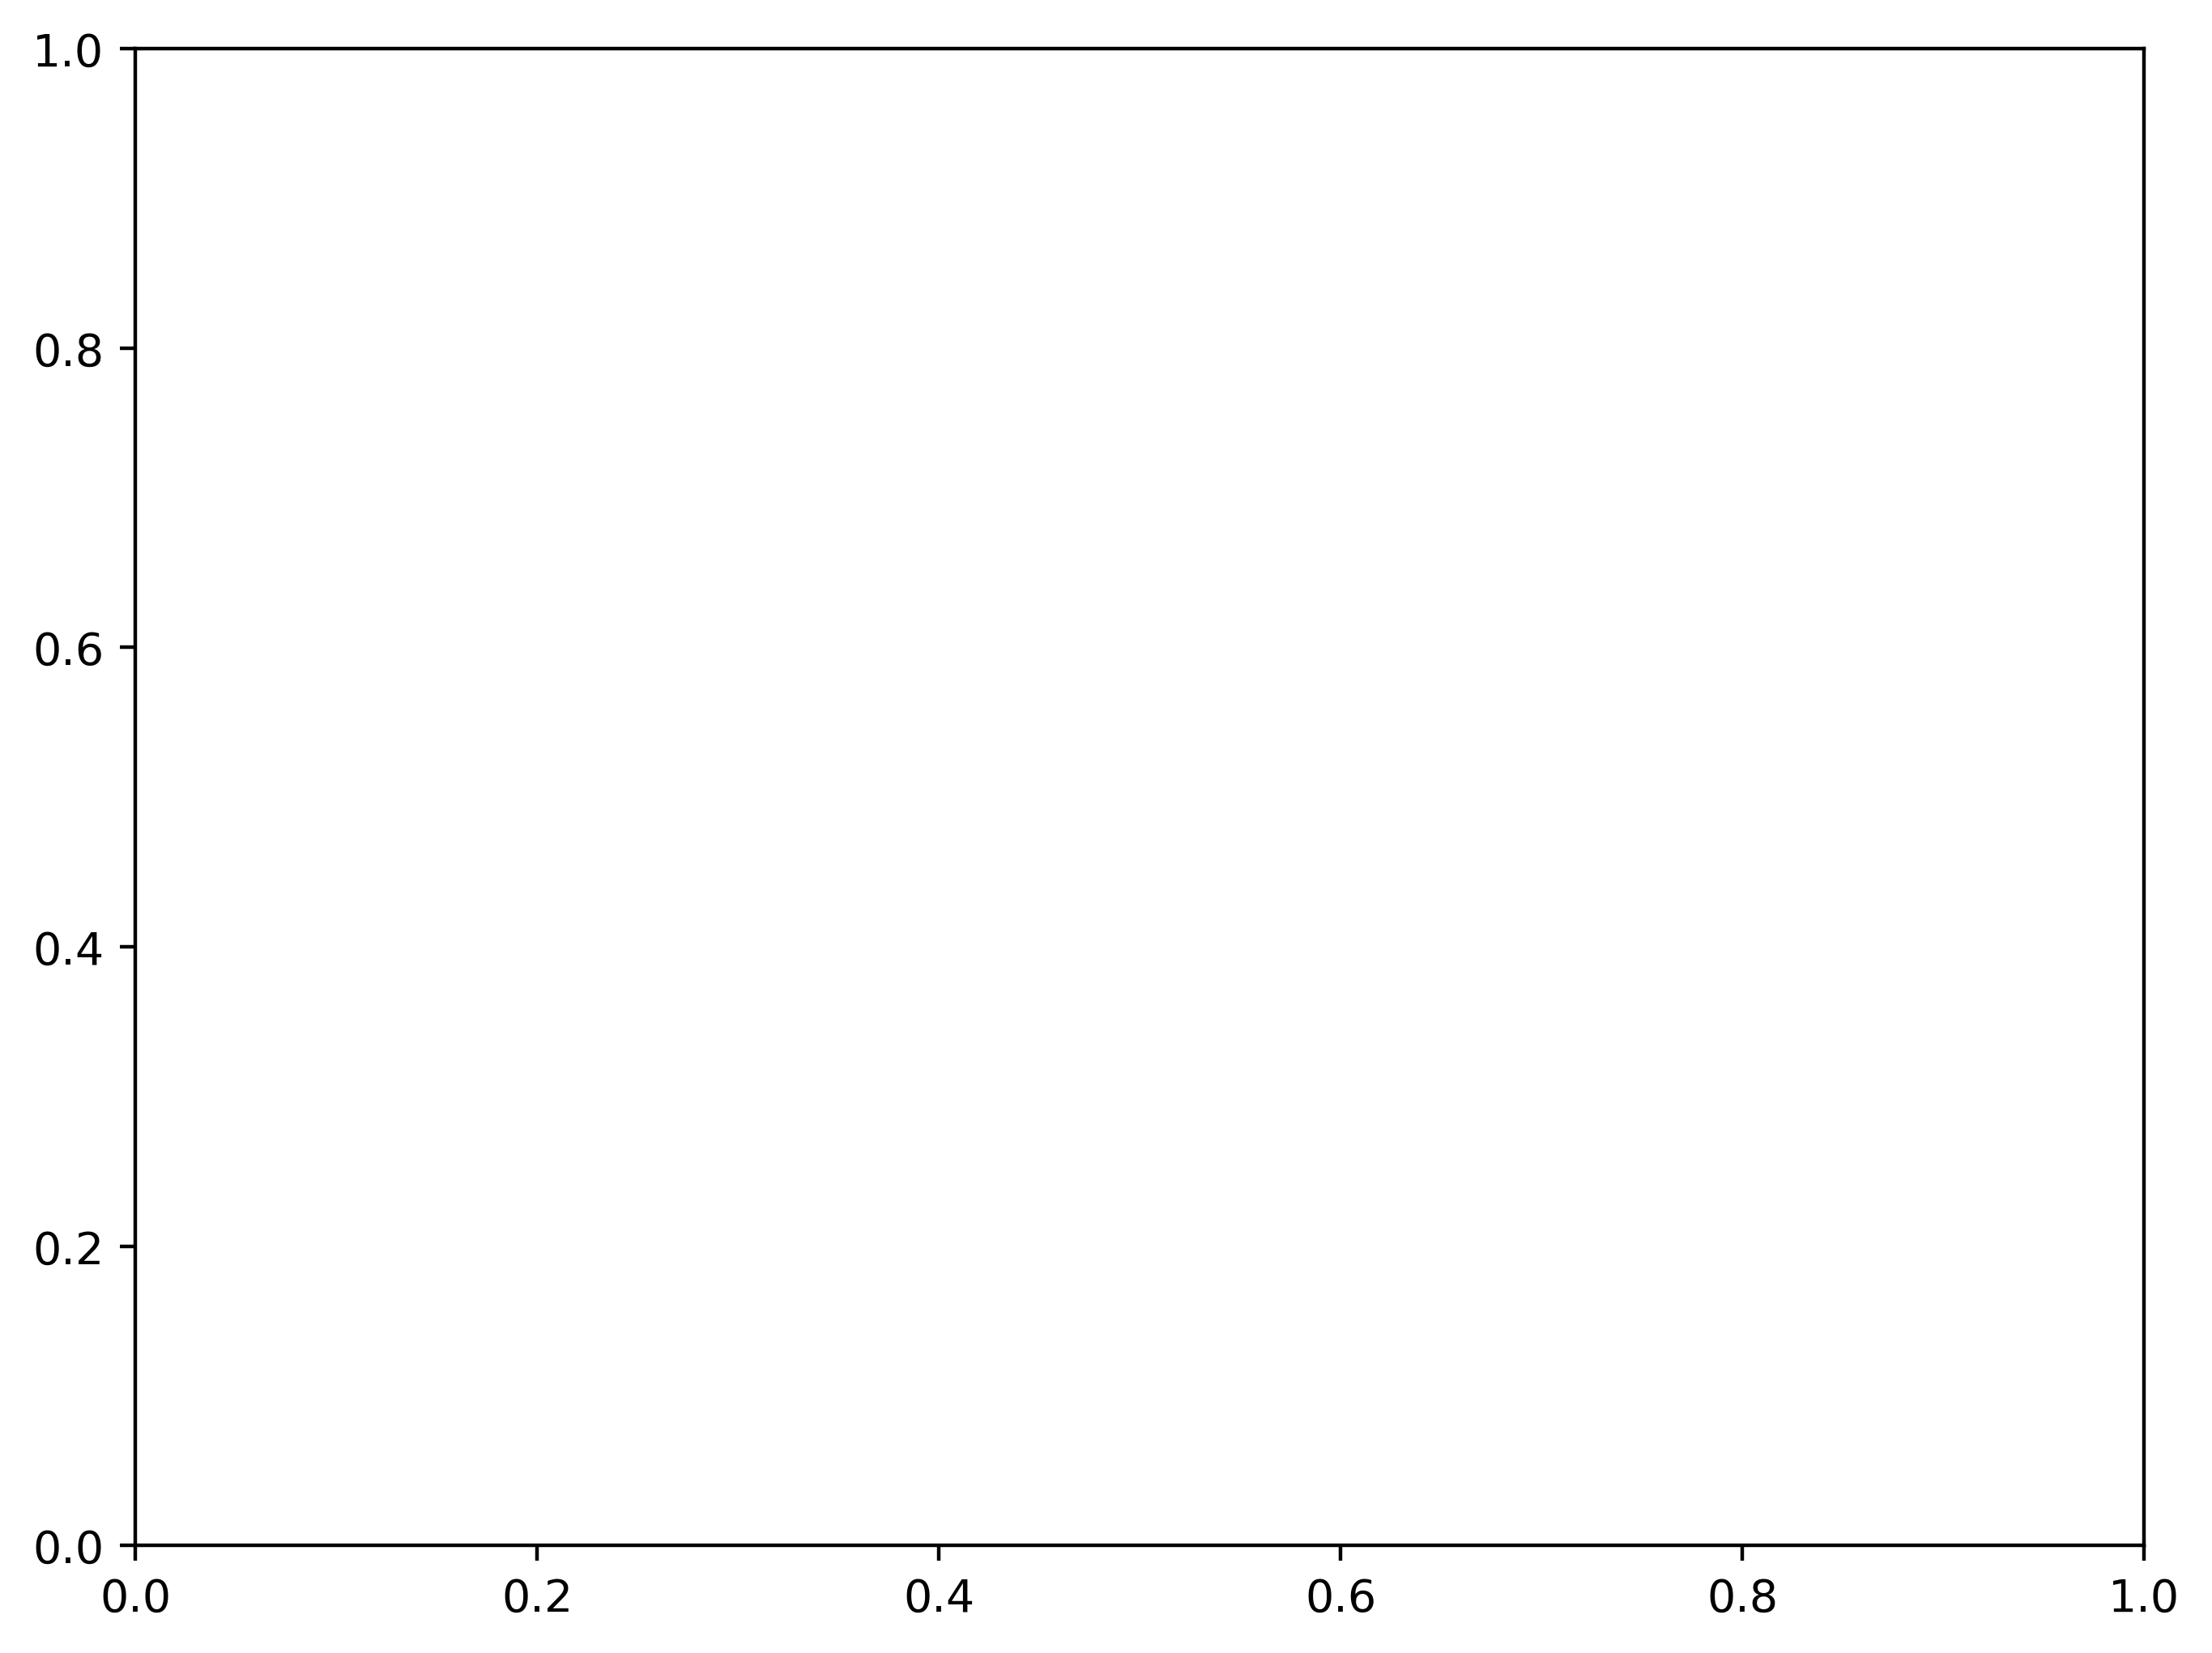

In [1008]:
fig = plt.figure(figsize=(8, 6), dpi=dpi)
ax = fig.add_subplot(111)

d = df
color_var = d.radius
scatter = ax.scatter(
    d.obs_n_gte_r,
    d.predicted_n_gte_r,
    c=color_var,
    s=0.75,
    norm=LogNorm(vmin=3, vmax=color_var.max()),
    cmap="viridis",
    alpha=0.5,
    linewidth=0.1
)

ax.set_xlabel("Observed $N(\\!\\geq r)$", fontsize=font_size)
ax.set_ylabel("Predicted $N(\\!\\geq r)$", fontsize=font_size)

cbar = fig.colorbar(scatter, ax=ax, label="r")
cbar.ax.tick_params(labelsize=10)

cbar.locator = LogLocator(base=10.0, numticks=10)
cbar.formatter = ScalarFormatter()
cbar.update_ticks()

ax.set_xscale('log')
ax.set_yscale('log')

plt.show()
# fig.savefig(f"figures/{scenario_name}_observed_vs_predicted_csfd.png", bbox_inches="tight")

# Hypothesis testing for b >= -2

In [904]:
target_ntot = int(1e6)

min_slope = -2
max_slope = 0
max_simulation_id = 230

selected_simulation_ids = list(configs_pdf[
    (configs_pdf.study_region_size == 1000)
    & (configs_pdf.slope <= max_slope)
    & (configs_pdf.slope >= min_slope)
    & (configs_pdf.simulation_id <= max_simulation_id)
].simulation_id.astype(int))

model_data = get_statistics_with_lifespans_for_simulations(
    selected_simulation_ids,
    base_path,
    configs_df,
    spark,
    n_samples_per_sim=10000
)
model_data

25/01/23 20:38:44 WARN SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 262144000 bytes). This may impact query planning performance.


,x,y,radius,simulation_id,ntot,nobs,areal_density,slope,mrp,rmult,rim_erasure_method_name,rim_erasure_radius_ratio,rim_erasure_exponent,lifespan
0,179.199631,1018.288818,3.222626,122,1388,1047,0.0,-1.6,0.5,1.0,NaN,2.0,0.5,91243
1,589.010864,382.920105,6.855876,122,3098,1446,0.0,-1.6,0.5,1.0,NaN,2.0,0.5,33787
2,980.628662,692.460083,25.383612,122,4339,1628,0.0,-1.6,0.5,1.0,NaN,2.0,0.5,14078
3,798.462708,873.911926,4.282919,122,9204,1707,0.0,-1.6,0.5,1.0,NaN,2.0,0.5,51798
4,541.972534,391.125854,5.192739,122,11069,1316,0.0,-1.6,0.5,1.0,NaN,2.0,0.5,12388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,824.057068,1079.371948,3.357057,37,438260,2071,0.0,-1.8,0.5,1.0,NaN,2.0,0.1,13052
9996,531.619385,1079.729736,3.111644,37,438640,2182,0.0,-1.8,0.5,1.0,NaN,2.0,0.1,78920
9997,563.727722,553.229614,7.752013,37,441382,2006,0.0,-1.8,0.5,1.0,NaN,2.0,0.1,93585
9998,960.287170,375.174408,6.510659,37,448037,2278,0.0,-1.8,0.5,1.0,NaN,2.0,0.1,167752


In [905]:
# Best model so far
model = smf.negativebinomial(data=model_data, formula="lifespan ~ 1 + slope:rim_erasure_exponent:np.log(radius) + rim_erasure_exponent:np.log(radius) + np.log(-slope) + slope").fit(maxiter=1000, method="BFGS", cov_type="HC0")

print(model.summary())
print(model.aic)

Optimization terminated successfully.
         Current function value: 11.150358
         Iterations: 31
         Function evaluations: 34
         Gradient evaluations: 34
                     NegativeBinomial Regression Results                      
Dep. Variable:               lifespan   No. Observations:               600000
Model:               NegativeBinomial   Df Residuals:                   599995
Method:                           MLE   Df Model:                            4
Date:                Thu, 23 Jan 2025   Pseudo R-squ.:                 0.04394
Time:                        20:39:44   Log-Likelihood:            -6.6902e+06
converged:                       True   LL-Null:                   -6.9977e+06
Covariance Type:                  HC0   LLR p-value:                     0.000
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [906]:
d = configs_dict[selected_simulation_ids[0]]
r_stat = d["r_stat"]
r_dist_min = d["r_min"]
r_dist_max = d["r_max"]

mp = model.params

df = None
for simulation_id in selected_simulation_ids:
    config = configs_dict[simulation_id]
    
    state = get_states_at_ntots(
        simulation_id=simulation_id,
        configs_dict=configs_dict,
        base_path=base_path,
        target_ntots=[target_ntot],
        spark=spark
    )[target_ntot]

    slope = config["slope"]
    rim_erasure_exponent = config["rim_erasure_method"]["exponent"]
    
    state["simulation_id"] = simulation_id
    state["slope"] = slope
    state["rim_erasure_exponent"] = rim_erasure_exponent

    predicted_slope = slope + (mp["slope:rim_erasure_exponent:np.log(radius)"] * slope * rim_erasure_exponent + mp["rim_erasure_exponent:np.log(radius)"] * rim_erasure_exponent)
    hypothetical_cdf = lambda x: truncated_pareto_cdf(x, -predicted_slope, r_stat, r_dist_max)
    ks_statistic, p_value = stats.kstest(state.radius, hypothetical_cdf)

    state["predicted_slope"] = predicted_slope
    state["ks_statistic"] = ks_statistic
    state["ks_p_value"] = p_value

    df = state if df is None else pd.concat([df, state], axis=0)

In [907]:
columns = [
    "simulation_id",
    "slope",
    "rim_erasure_exponent",
    "predicted_slope",
    "ks_statistic",
    "ks_p_value",
]
hypothesis_test_results = df[columns].drop_duplicates()

In [908]:
# How many hypothesis tests were significant?
(hypothesis_test_results.ks_p_value < 0.05).mean()

0.95

In [909]:
comparison_value = (hypothesis_test_results.ks_p_value < 0.95)
print(stats.pearsonr(comparison_value, hypothesis_test_results.rim_erasure_exponent))
print(stats.pearsonr(comparison_value, hypothesis_test_results.slope))
print(stats.pearsonr(comparison_value, hypothesis_test_results.slope * hypothesis_test_results.rim_erasure_exponent))

PearsonRResult(statistic=-0.013312051063847849, pvalue=0.919590141981871)
PearsonRResult(statistic=-0.20149814827784024, pvalue=0.12262527299107)
PearsonRResult(statistic=-0.06609602277278229, pvalue=0.6158385482424747)


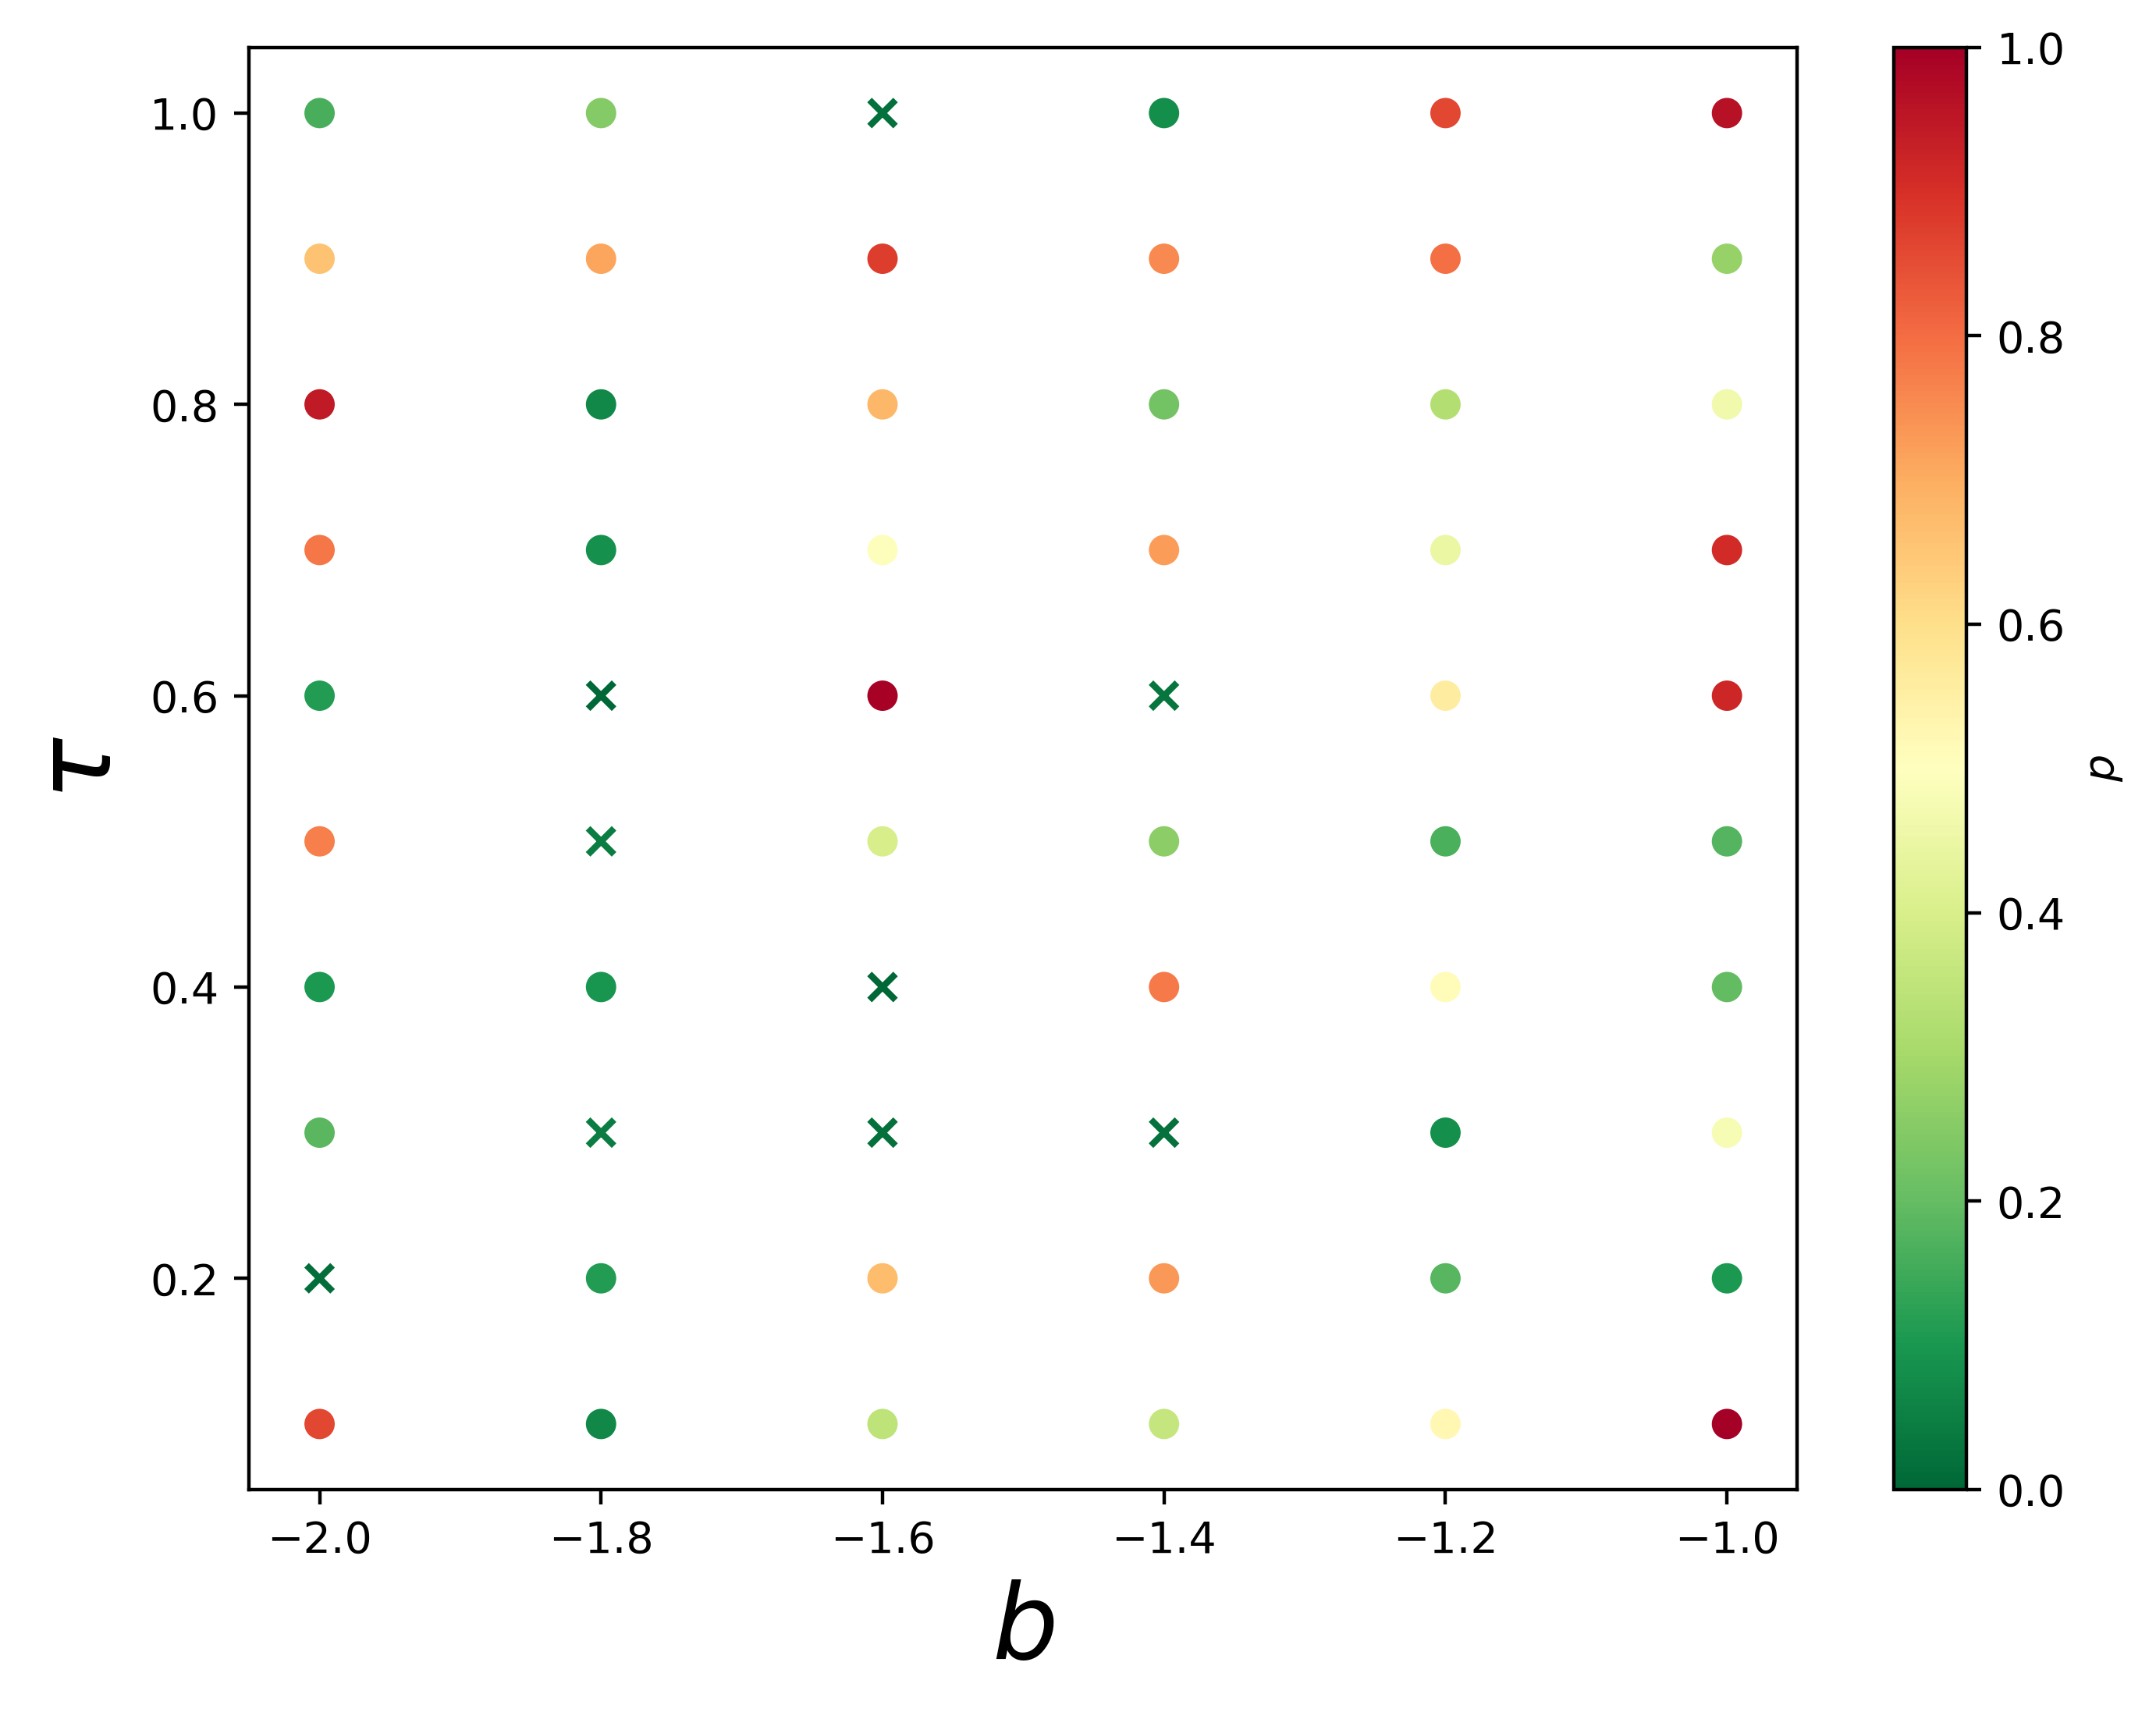

In [914]:
significance_level = 0.05

fig = plt.figure(figsize=(8, 6), dpi=dpi)
ax = fig.add_subplot(111)

norm = Normalize(vmin=0.0, vmax=1.0) 

subset = hypothesis_test_results[hypothesis_test_results.ks_p_value < significance_level]
color_var = subset.ks_p_value
scatter = ax.scatter(
    subset.slope,
    subset.rim_erasure_exponent,
    marker="x",
    c=color_var,
    norm=norm,
    cmap="RdYlGn_r"
)

subset = hypothesis_test_results[hypothesis_test_results.ks_p_value >= significance_level]
color_var = subset.ks_p_value
scatter = ax.scatter(
    subset.slope,
    subset.rim_erasure_exponent,
    marker="o",
    c=color_var,
    norm=norm,
    cmap="RdYlGn_r"
)

ax.set_xlabel("$b$", fontsize=font_size)
ax.set_ylabel("$\\tau$", fontsize=font_size)

cbar = fig.colorbar(scatter, ax=ax, label="$p$")
cbar.ax.tick_params(labelsize=10)
cbar.update_ticks()

plt.show()
# fig.savefig(f"figures/{scenario_name}_observed_vs_predicted_csfd.png", bbox_inches="tight")

In [1006]:
# fig = px.scatter_3d(
#     hypothesis_test_results, 
#     x="slope", 
#     y="rim_erasure_exponent", 
#     z="ks_p_value", 
# )

# fig.update_traces(marker=dict(size=2)) 

# fig.update_layout(
#     height=800,
#     width=1200,
# )

# fig.show()

In [995]:
selected_simulation_id = 237
selected_config = configs_dict[selected_simulation_id]

slope = selected_config["slope"]
rim_erasure_exponent = selected_config["rim_erasure_method"]["exponent"]
ntot = selected_config["stop_condition"]["ntot"]
r_min = selected_config["r_min"]

state = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    target_ntots=[selected_ntot],
    spark=spark
)[selected_ntot]

state = state.sort_values("radius")
production_function = state.radius ** slope
mle_estimated_slope, ml_estimated_slope_sigma = estimate_slopes_for_states({simulation_id: state}, configs_dict[simulation_id]["r_stat"])[["alpha", "sigma"]].loc[0]

state["slope"] = slope
state["rim_erasure_exponent"] = rim_erasure_exponent
state["kappa_predicted"] = model.predict(state)

state["analytical_model_prediction"] = production_function * state.kappa_predicted
state["analytical_model_prediction"] = state.analytical_model_prediction / state.analytical_model_prediction.max() * state.shape[0]

state1 = state

In [996]:
mp = model.params
predicted_slope = slope + (mp["slope:rim_erasure_exponent:np.log(radius)"] * slope * rim_erasure_exponent + mp["rim_erasure_exponent:np.log(radius)"] * rim_erasure_exponent)

print(f"MLE estimated slope: {mle_estimated_slope:.3f}, sigma: {ml_estimated_slope_sigma:.3f}")
print(f"Predicted slope: {predicted_slope:.3f}")

MLE estimated slope: -4.878, sigma: 0.869
Predicted slope: -4.956


In [1002]:
hypothetical_cdf = lambda x: truncated_pareto_cdf(x, -predicted_slope, r_stat, r_dist_max)
ks_statistic, p_value = stats.kstest(state.radius, hypothetical_cdf)
print(ks_statistic, p_value)

0.07995707468247748 0.7239608723252489


In [1003]:
selected_simulation_id = 236
selected_config = configs_dict[selected_simulation_id]

slope = selected_config["slope"]
rim_erasure_exponent = selected_config["rim_erasure_method"]["exponent"]
ntot = selected_config["stop_condition"]["ntot"]
r_min = selected_config["r_min"]

state = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    target_ntots=[selected_ntot],
    spark=spark
)[selected_ntot]

state = state.sort_values("radius")
production_function = state.radius ** slope
mle_estimated_slope, ml_estimated_slope_sigma = estimate_slopes_for_states({simulation_id: state}, configs_dict[simulation_id]["r_stat"])[["alpha", "sigma"]].loc[0]

state["slope"] = slope
state["rim_erasure_exponent"] = rim_erasure_exponent
state["kappa_predicted"] = model.predict(state)

state["analytical_model_prediction"] = production_function * state.kappa_predicted
state["analytical_model_prediction"] = state.analytical_model_prediction / state.analytical_model_prediction.max() * state.shape[0]

state2 = state

In [1004]:
mp = model.params
predicted_slope = slope + (mp["slope:rim_erasure_exponent:np.log(radius)"] * slope * rim_erasure_exponent + mp["rim_erasure_exponent:np.log(radius)"] * rim_erasure_exponent)

print(f"MLE estimated slope: {mle_estimated_slope:.3f}, sigma: {ml_estimated_slope_sigma:.3f}")
print(f"Predicted slope: {predicted_slope:.3f}")

MLE estimated slope: -4.394, sigma: 0.599
Predicted slope: -4.972


In [1005]:
hypothetical_cdf = lambda x: truncated_pareto_cdf(x, -predicted_slope, r_stat, r_dist_max)
ks_statistic, p_value = stats.kstest(state.radius, hypothetical_cdf)
print(ks_statistic, p_value)

0.07606687762520531 0.883912598659489


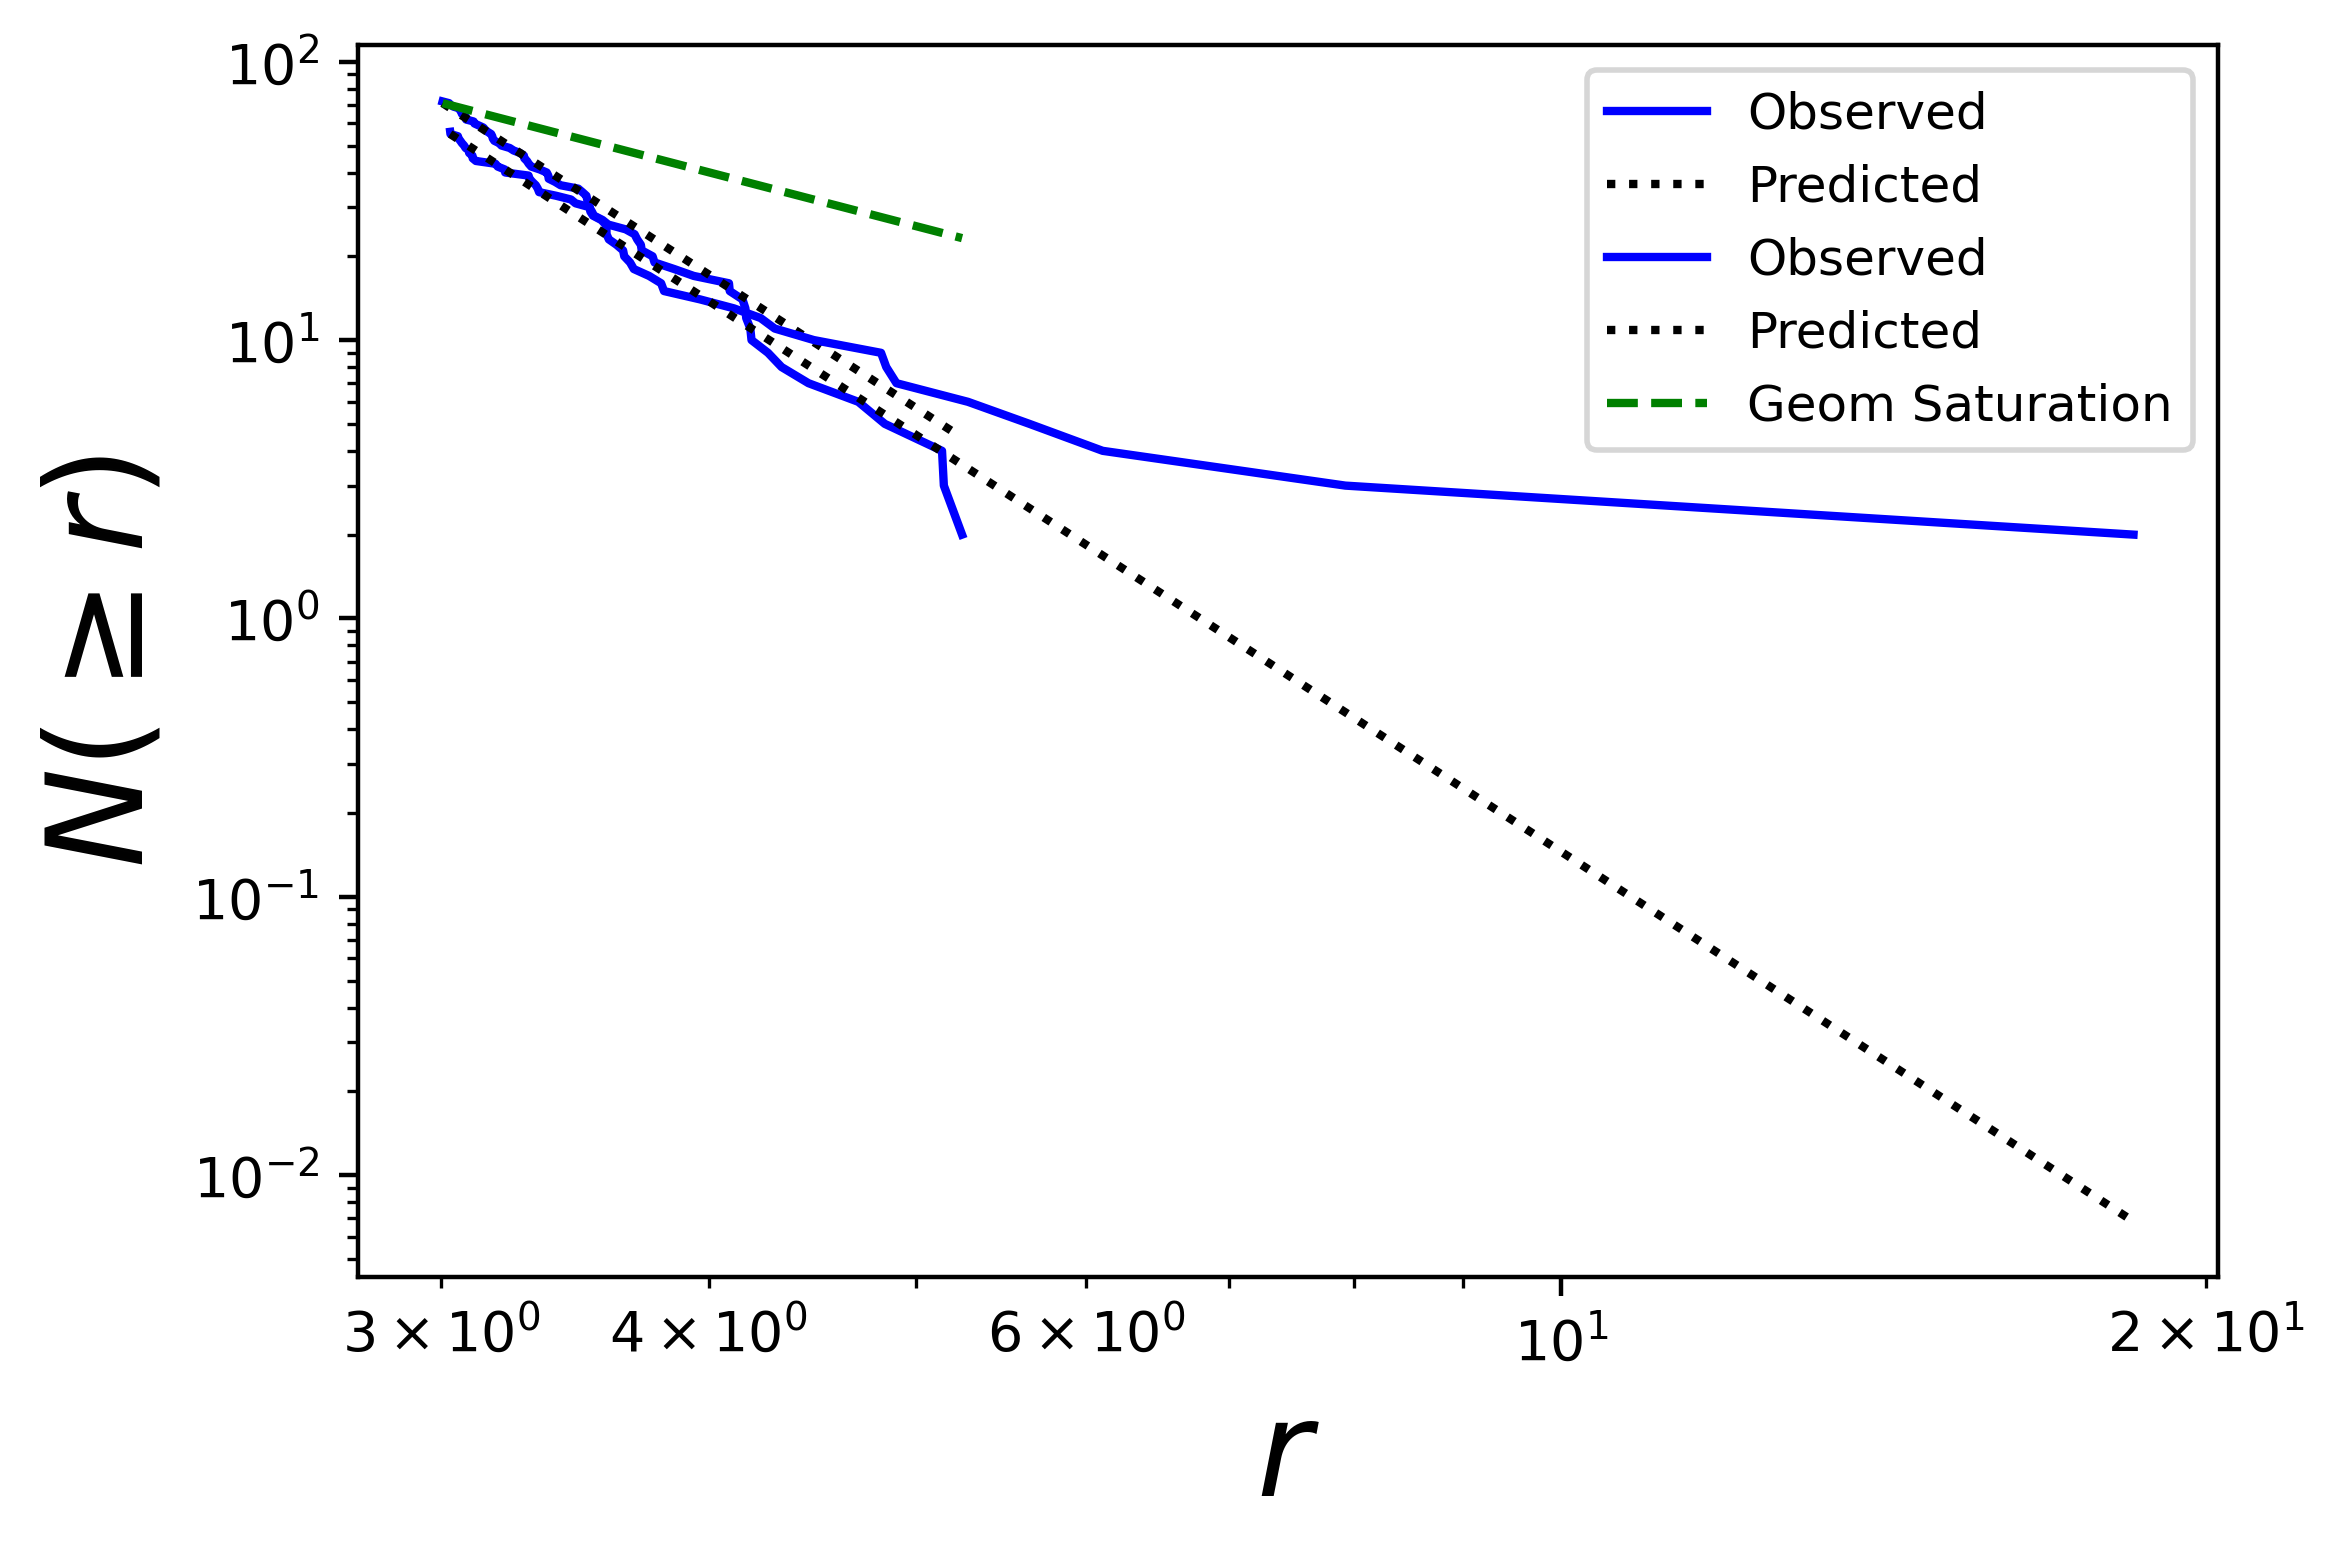

In [999]:
fig = plt.figure(figsize=(6, 4), dpi=dpi)
ax = fig.add_subplot(111)

state = state1
ax.plot(state.radius, range(len(state.radius) + 1, 1, -1), label="Observed", c="blue")
ax.plot(
    state.radius,
    state.analytical_model_prediction,
    ls="dotted",
    c="black",
    label="Predicted"
)


state = state2
ax.plot(state.radius, range(len(state.radius) + 1, 1, -1), label="Observed", c="blue")

production_function = state.radius ** slope

state["slope"] = slope
state["rim_erasure_exponent"] = rim_erasure_exponent
state["kappa_predicted"] = model.predict(state)

state["analytical_model_prediction"] = production_function * state.kappa_predicted
state["analytical_model_prediction"] = state.analytical_model_prediction / state.analytical_model_prediction.max() * state.shape[0]
ax.plot(
    state.radius,
    state.analytical_model_prediction,
    ls="dotted",
    c="black",
    label="Predicted"
)


state = state1
state["geometric_saturation_prediction"] = state.radius**-2
state["geometric_saturation_prediction"] = state.geometric_saturation_prediction / state.geometric_saturation_prediction.max() * state.shape[0]
ax.plot(
    state.radius,
    state.geometric_saturation_prediction,
    ls="dashed",
    c="green",
    label="Geom Saturation"
)

ax.set_xlabel("$r$", fontsize=font_size)
ax.set_ylabel("$N(\\geq r)$", fontsize=font_size)

ax.legend(fontsize=9)
ax.set_xscale('log')
ax.set_yscale('log')

plt.show()
fig.savefig(f"figures/{scenario_name}_observed_vs_predicted_csfd.png", bbox_inches="tight")

# Constructing a model for $b \leq -3$

In [ ]:
residuals = model.resid_pearson
plt.hist(residuals, bins=30)
plt.title("Histogram of Pearson Residuals")
plt.show()

In [ ]:
# Perform the Breusch-Pagan test
bp_test = het_breuschpagan(model.resid_pearson, model.model.exog)
bp_labels = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]

print("Breusch-Pagan Test:")
print(dict(zip(bp_labels, bp_test)))

# Perform the White test
white_test = het_white(model.resid_pearson, model.model.exog)
white_labels = ["Test Statistic", "p-value", "f-value", "f p-value"]

print("\nWhite Test:")
print(dict(zip(white_labels, white_test)))

# Interpretation:
# A small p-value (e.g., < 0.05) suggests evidence of heteroscedasticity.

In [ ]:
for i in range(1, len(model.model.exog_names) - 1):  # Skip the intercept and alpha
    plt.scatter(model.model.exog[:, i], model.resid_pearson)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel(f"Predictor {model.model.exog_names[i]}")
    plt.ylabel("Pearson Residuals")
    plt.title(f"Residuals vs. Predictor {model.model.exog_names[i]}")
    plt.show()

In [ ]:
# Plot Pearson residuals vs fitted values
data["fitted_values"] = model.fittedvalues
data["log_fitted_values"] = np.log(model.fittedvalues)
data["log_radius"] = np.log(data.radius)
data["log_lifespan"] = np.log(data.lifespan)
var_names = ["slope", "log_radius", "radius", "fitted_values", "lifespan", "rim_erasure_exponent"]
for var_name in var_names:
    plt.scatter(data[var_name], model.resid_pearson, alpha=0.5)
    plt.axhline(0, color="red", linestyle="--")
    plt.xlabel(var_name)
    plt.ylabel("Pearson residuals")
    plt.title(f"Pearson Residuals vs. {var_name}")
    plt.show()

In [ ]:
# How about for b <= -4.5?
data = df[df.slope <= -4.5].copy()
model = smf.negativebinomial(data=data, formula="lifespan ~ 1 + slope:rim_erasure_exponent:np.log(radius) + rim_erasure_exponent:np.log(radius) + np.log(-slope) + slope").fit(maxiter=1000, method="BFGS", cov_type="HC0")

print(model.summary())
print(model.aic)

In [ ]:
# How about for b >= -4.5?
data = df[df.slope >= -4.5].copy()
model = smf.negativebinomial(data=data, formula="lifespan ~ 1 + slope:rim_erasure_exponent:np.log(radius) + rim_erasure_exponent:np.log(radius) + np.log(-slope) + slope").fit(maxiter=1000, method="BFGS", cov_type="HC0")

print(model.summary())
print(model.aic)

In [ ]:
data = pd.read_parquet("/data/saturation/thesis_run_20250108/kappa_simulation_results.parquet")
data

In [ ]:
d = data[data.alpha > 3].copy()
d["fixed_slope"] = d.alpha - 2
d["mod_slope"] = d.fixed_slope / d.alpha / np.exp(d.alpha)
model = smf.negativebinomial(data=d, formula="kappa ~ 1 + fixed_slope:tau:np.log(r) + np.log(mod_slope)").fit(maxiter=1000, method="Powell", cov_type="HC0")
model.summary()

In [ ]:
d = data[data.alpha >= 3].copy()
model = smf.negativebinomial(data=d, formula="kappa ~ 1 + alpha*tau*np.log(r)").fit(maxiter=1000, method="Powell", cov_type="HC0")
print(model.summary())
print(model.aic)

In [ ]:
# Best so far
d = data[data.alpha > 3].copy()
model = smf.negativebinomial(data=d, formula="kappa ~ 1 + alpha:tau:np.log(r) + tau:np.log(r) + alpha").fit(maxiter=1000, method="Powell", cov_type="HC0")
print(model.summary())
print(model.aic)

In [ ]:
d = data[data.alpha > 3].copy()
model = smf.negativebinomial(data=d, formula="kappa ~ 1 + I(alpha - 2):tau:np.log(r) + alpha + np.log(alpha)").fit(maxiter=1000, method="Powell", cov_type="HC0")
print(model.summary())
print(model.aic)

In [ ]:
d = data[data.alpha > 3].copy()
model = smf.negativebinomial(data=d, formula="kappa ~ 1 + alpha*tau*np.log(r)").fit(maxiter=1000, method="Powell", cov_type="HC0")
print(model.summary())
print(model.aic)

In [ ]:
d = data[data.alpha > 3].copy()
model = smf.negativebinomial(data=d, formula="kappa ~ 1 + alpha*tau*np.log(r) - alpha - tau - alpha:tau + np.log(alpha)").fit(maxiter=1000, method="Powell", cov_type="HC0")
print(model.summary())
print(model.aic)

In [ ]:
d = data[data.alpha.between(3, 4)].copy()
model = smf.negativebinomial(data=d, formula="kappa ~ 1 + alpha*tau*np.log(r) - tau - alpha:tau - alpha:np.log(r)").fit(maxiter=1000, method="Powell", cov_type="HC0")
print(model.summary())
print(model.aic)

In [ ]:
d = data[data.alpha.between(5, 6)].copy()
model = smf.negativebinomial(data=d, formula="kappa ~ 1 + alpha*tau*np.log(r) - tau - alpha:tau - alpha:np.log(r)").fit(maxiter=1000, method="Powell", cov_type="HC0")
print(model.summary())
print(model.aic)

In [ ]:
d = data[data.alpha < 1.2].copy()
model = smf.negativebinomial(data=d, formula="kappa ~ 1 + alpha*tau*np.log(r)").fit(maxiter=1000, method="BFGS", cov_type="HC0")
print(model.summary())
print(model.aic)

In [ ]:
d = data[data.alpha > 3].copy()
d["fixed_alpha"] = d.alpha - 2
model = smf.negativebinomial(data=d, formula="kappa ~ 1 + alpha*tau*np.log(r) + np.log(fixed_alpha)").fit(maxiter=1000, method="Powell", cov_type="HC0")
print(model.summary())
print(model.aic)

In [ ]:
d = data[data.alpha > 3].copy()
d["fixed_alpha"] = d.alpha - 2
model = smf.negativebinomial(data=d, formula="kappa ~ 1 + alpha:tau:np.log(r) + tau:np.log(r) + alpha + np.log(fixed_alpha) + np.log(alpha)").fit(maxiter=1000, method="BFGS", cov_type="HC0")
print(model.summary())
print(model.aic)

In [ ]:
d = data[data.alpha.between(3, 4)].copy()
d["fixed_slope"] = d.alpha - 2
d["mod_slope"] = d.fixed_slope / d.alpha
model = smf.negativebinomial(data=d, formula="kappa ~ 1 + alpha:tau:np.log(r) + tau:np.log(r) + alpha").fit(maxiter=1000, method="BFGS", cov_type="HC0")
print(model.summary())
print(model.aic)

In [ ]:
d = data[data.alpha.between(3, 4)].copy()
d["fixed_slope"] = d.alpha - 2
d["mod_slope"] = d.fixed_slope / d.alpha
model = smf.negativebinomial(data=d, formula="kappa ~ 1 + alpha:tau:np.log(r) + tau:np.log(r) + alpha").fit(maxiter=1000, method="Powell", cov_type="HC0")
print(model.summary())
print(model.aic)

In [ ]:
d = data[data.alpha.between(3, 4)].copy()
d["fixed_slope"] = d.alpha - 2
d["mod_slope"] = d.fixed_slope / d.alpha
model = smf.negativebinomial(data=d, formula="kappa ~ 1 + fixed_slope:tau:np.log(r) + alpha").fit(maxiter=1000, method="Powell", cov_type="HC0")
print(model.summary())
print(model.aic)

In [ ]:
d = data[data.alpha.between(3, 4)].copy()
d["fixed_slope"] = d.alpha - 2
d["mod_slope"] = d.fixed_slope / d.alpha
model = smf.negativebinomial(data=d, formula="kappa ~ 1 + alpha:tau:np.log(r) + tau:np.log(r) + alpha").fit(maxiter=1000, method="Powell", cov_type="HC0")
model.summary()

In [ ]:
d = data[data.alpha.between(5, 6)].copy()
d["fixed_slope"] = d.alpha - 2
d["mod_slope"] = d.fixed_slope / d.alpha
model = smf.negativebinomial(data=d, formula="kappa ~ 1 + alpha:tau:np.log(r) + tau:np.log(r) + alpha").fit(maxiter=1000, method="Powell", cov_type="HC0")
model.summary()

In [ ]:
data.tau.drop_duplicates()

In [ ]:
d = data[(np.abs(data.alpha - 4.061224) < 0.01) & (np.abs(data.tau - 0.6) < 0.01)]
model = smf.negativebinomial(data=d, formula="kappa ~ 1 + np.log(r)").fit(maxiter=1000, method="Powell", cov_type="HC0")
model.summary()

In [ ]:
(4.06 - 2) * 0.6

In [ ]:
plt.hist(np.log(data[(data.alpha == 1.0) & (data.tau == 1.0)].kappa))

In [ ]:
data = pd.read_parquet("/data/saturation/thesis_run_20250108/kappa_simulation_results.parquet")
data

In [ ]:
pm.summary(trace)

In [ ]:
data = pd.read_parquet("/data/saturation/thesis_run_20250108/kappa_simulation_results.parquet")
data

In [ ]:
grouped_data = data.groupby(["r", "alpha", "tau"])["kappa"].agg(["mean", "var"]).reset_index()

In [ ]:
d = data[data.alpha.between(3, 4)].copy()
# d["kappa"] = d.kappa / d.kappa.mean()
d["fixed_alpha"] = d.alpha - 2
d["mod_alpha"] = d.fixed_alpha / d.alpha / np.exp(d.alpha)
model = smf.negativebinomial(data=d, formula="kappa ~ 1 + alpha:tau:np.log(r) + tau:np.log(r) + alpha").fit(maxiter=1000, method="Powell", cov_type="HC0")
print(model.summary())
print(model.aic)

In [ ]:
d = grouped_data[grouped_data.alpha.between(3, 5)].copy()
model = smf.negativebinomial(data=d, formula="mean ~ 1 + alpha:tau:np.log(r) + tau:np.log(r) + alpha").fit(maxiter=1000, method="Powell", cov_type="HC0")
print(model.summary())
print(model.aic)

In [ ]:
grouped_data

In [ ]:
data = pd.read_parquet("/data/saturation/thesis_run_20250108/kappa_simulation_results.parquet")

In [ ]:
grouped_data = data.groupby(["r", "alpha", "tau"])["kappa"].agg(["mean", "var"]).reset_index()
plt.scatter(np.log(grouped_data["var"]), np.log(grouped_data["mean"]))

In [ ]:
import plotly.express as px

d = pd.read_parquet("/data/saturation/thesis_run_20250108/kappa_simulation_results.parquet")
d = d[d.alpha >= 3]
d = d.groupby(["r", "alpha", "tau"])["kappa"].agg(["mean", "var"]).reset_index()
d["log_r"] = np.log(d.r)
d["kappa_mean"] = d["mean"]
d["kappa_var"] = d["var"]
d["log_kappa_mean"] = np.log(d["mean"])
d["log_kappa_var"] = np.log(d["var"])

# Assuming d is your pandas dataframe
fig = px.scatter_3d(
    d, 
    x='alpha', 
    y='tau', 
    z='log_r', 
    color='log_kappa_var',
    color_continuous_scale='Viridis',
)

fig.update_traces(marker=dict(size=2)) 

fig.update_layout(
    height=800,
    width=1200,
)

fig.show()

In [ ]:
model = smf.ols(data=grouped_data, formula="var ~ mean + I(mean**2)").fit()
print(model.summary())
print(model.aic)

In [ ]:
plt.scatter(grouped_data.r, model.resid_pearson)

In [ ]:
plt.scatter(grouped_data.alpha, model.resid_pearson)

In [ ]:
plt.scatter(grouped_data.tau, model.resid_pearson)


In [ ]:
grouped_data["resid"] = model.resid_pearson
# g = grouped_data[grouped_data.resid < 3].copy()
# g["log_resid"] = np.log(g.resid - g.resid.min() + 1)
# plt.hist(g.log_resid)

In [ ]:
plt.hist(data[(data.alpha == 5) & (data.tau == 1) & (data.r > 700)].kappa)

In [ ]:
g.describe()

In [ ]:
import plotly.express as px

fig = px.scatter_3d(
    g, 
    x='r', 
    y='alpha', 
    z='mean', 
    color='resid',
    color_continuous_scale='Viridis',
)

fig.update_traces(marker=dict(size=2)) 

fig.update_layout(
    height=800,
    width=800,
)

fig.show()


In [ ]:
d = d[(d["var"] != 0) & (d.alpha > 3)].copy()
d["log_kappa_mean"] = np.log(d["mean"])
d["log_kappa_var"] = np.log(d["var"])
d["kappa_mean"] = d["mean"]
d["kappa_var"] = d["var"]
d["log_r"] = np.log(d.r)

In [ ]:
import plotly.express as px

# Assuming d is your pandas dataframe
fig = px.scatter_3d(
    d, 
    x='log_r', 
    y='alpha', 
    z='tau', 
    color='log_kappa_var',
    title='3D Scatter Plot colored by kappa',
    labels={'r': 'Radius (r)', 'alpha': 'Alpha', 'tau': 'Tau', 'kappa': 'Kappa'},
    color_continuous_scale='Viridis',
)

fig.update_traces(marker=dict(size=2)) 

fig.update_layout(
    scene=dict(
        xaxis_title='R',
        yaxis_title='Alpha',
        zaxis_title='Tau'
    ),
    height=800,
    width=800,
    coloraxis_colorbar=dict(title='Kappa')
)

fig.show()


In [ ]:
plt.scatter(d.log_r, d.kappa_var)

In [ ]:
d["kappa_mean_sq"] = d.kappa_mean ** 2
model = smf.ols(data=d, formula="kappa_var ~ kappa_mean + kappa_mean_sq - 1 + alpha + r").fit(cov_type="HC0")
print(model.summary())
print(model.aic)

In [ ]:
d["kappa_mean_sq"] = d.kappa_mean ** 2
model = smf.ols(data=d, formula="np.log(kappa_var) ~ 1 + np.log(kappa_mean_sq)*alpha*tau*np.log(r) - np.log(kappa_mean_sq):alpha - np.log(kappa_mean_sq):alpha:tau - tau:np.log(r) - np.log(kappa_mean_sq):alpha:np.log(r) - np.log(kappa_mean_sq):tau:np.log(r) - np.log(r) - alpha").fit(cov_type="HC0")
print(model.summary())
print(model.aic)

In [ ]:
plt.scatter(d.r, model.resid_pearson)

In [ ]:
plt.scatter(d.alpha, model.resid_pearson)

In [ ]:
plt.scatter(d.tau, model.resid_pearson)

# Modeling kappa from limited simulations

In [42]:
data = pd.read_parquet("/data/saturation/thesis_run_20250108/kappa_simulation_results.parquet")
data = data[data.alpha.between(2.99, 4.01)].sample(frac=0.1).copy()

In [43]:
data.describe()

,r,alpha,tau,kappa
count,160000.000000,160000.000000,160000.000000,1.600000e+05
mean,205.660273,3.580867,0.572987,1.986272e+10
std,274.562873,0.287868,0.259409,1.826127e+11
min,5.000000,3.194737,0.145000,2.254760e+05
25%,20.160635,3.452632,0.370000,3.321304e+07
50%,81.290243,3.452632,0.595000,1.344496e+08
75%,327.772590,3.710526,0.820000,1.056277e+09
max,1000.000000,3.968421,1.000000,9.013001e+12


In [44]:
# Best model so far
model = smf.negativebinomial(data=data, formula="kappa ~ 1 + alpha:tau:np.log(r) + tau:np.log(r) + np.log(alpha) + alpha").fit(maxiter=1000, method="Powell", cov_type="HC0")

print(model.summary())
print(model.aic)

Optimization terminated successfully.
         Current function value: 19.390858
         Iterations: 3
         Function evaluations: 346
                     NegativeBinomial Regression Results                      
Dep. Variable:                  kappa   No. Observations:               160000
Model:               NegativeBinomial   Df Residuals:                   159995
Method:                           MLE   Df Model:                            4
Date:                Wed, 15 Jan 2025   Pseudo R-squ.:                  0.1274
Time:                        19:05:50   Log-Likelihood:            -3.1025e+06
converged:                       True   LL-Null:                   -3.5554e+06
Covariance Type:                  HC0   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              14.3286      0.067    213.812 

In [45]:
# Best model so far
model = smf.negativebinomial(data=data, formula="kappa ~ 1 + alpha:tau:np.log(r) + tau:np.log(r) + np.log(alpha) + alpha:tau").fit(maxiter=1000, method="Powell", cov_type="HC0")

print(model.summary())
print(model.aic)

Optimization terminated successfully.
         Current function value: 19.379024
         Iterations: 3
         Function evaluations: 249
                     NegativeBinomial Regression Results                      
Dep. Variable:                  kappa   No. Observations:               160000
Model:               NegativeBinomial   Df Residuals:                   159995
Method:                           MLE   Df Model:                            4
Date:                Wed, 15 Jan 2025   Pseudo R-squ.:                  0.1279
Time:                        19:05:56   Log-Likelihood:            -3.1006e+06
converged:                       True   LL-Null:                   -3.5554e+06
Covariance Type:                  HC0   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              15.4047      0.018    846.983 

# Comparing with the analytical model

In [4]:
def expected_area(x, x_min, x_max, alpha, tau, gamma):
    r_threshold = x**tau / gamma
    r_threshold = np.maximum(r_threshold, x_min)
    factor = alpha / (1 - (x_min / x_max)**alpha)

    E_R2 = np.where(
        alpha != 2,
        factor * (x_max**(2 - alpha) - r_threshold**(2 - alpha)) / (2 - alpha),
        (x_min**2 * np.log(x_max / r_threshold)) / (1 - (x_min / x_max)**2)
    )

    return np.pi * E_R2

In [5]:
d = pd.read_parquet("/data/saturation/thesis_run_20250108/kappa_simulation_results.parquet")
d = d[(d.alpha >= 0) & (d.tau >= 0.1)].copy()
g = d.groupby(["r", "alpha", "tau"])["kappa"].agg(["median", "mean", "var"]).reset_index()
g.rename({"median": "kappa_median", "mean": "kappa_mean", "var": "kappa_var"}, axis=1, inplace=True)

In [6]:
n_tau_values = 20
r_min = 5.0
r_max = 1000.0
r_dist_max = r_max * 4
tau_min = 0.1
tau_max = 1.0
gamma = 2.0
mrp = 0.5

r_dist_min = r_min ** (tau_min + (tau_max - tau_min) / n_tau_values) / 2
S = r_max + r_dist_max

In [7]:
c = g.alpha * np.pi * r_dist_min**g.alpha / ((g.alpha - 2) * S**2)
g["expected_kappa"] = np.log(mrp) / (np.log(1 - c * (g.r / gamma)**((2 - g.alpha) * g.tau)))
g["log_expected_kappa"] = np.log(g.expected_kappa)
g["resid"] = g.expected_kappa / g.kappa_mean
g["log_r"] = np.log(g.r)
g["log_resid"] = np.log(g.resid)
g["log_kappa_mean"] = np.log(g.kappa_mean)
(g.resid.abs()).mean()

/home/mason/code/saturation/venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/mason/code/saturation/venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


376.80484164437644

In [8]:
ex = expected_area(g.r, r_dist_min, r_dist_max, g.alpha, g.tau, gamma) / S**2
g["expected_kappa"] = np.log(mrp) / np.log(1 - ex)
g["log_expected_kappa"] = np.log(g.expected_kappa)
g["resid"] = g.expected_kappa / g.kappa_mean
g["log_r"] = np.log(g.r)
g["log_resid"] = np.log(g.resid)
g["log_kappa_mean"] = np.log(g.kappa_mean)
(g.resid.abs()).mean()

0.10369990952949891

In [9]:
g["alpha:tau"] = g.alpha * g.tau
g["r_alpha"] = g.r ** g.alpha

In [10]:
g[g.alpha < 1.5]

,r,alpha,tau,kappa_median,kappa_mean,kappa_var,expected_kappa,log_expected_kappa,resid,log_r,log_resid,log_kappa_mean,alpha:tau,r_alpha
0,5.0,0.100000,0.145,250931.0,384426.256,4.443416e+10,8.405463,2.128882,0.000022,1.609438,-10.730625,12.859507,0.014500,1.174619
1,5.0,0.100000,0.190,249848.0,372023.672,4.148348e+10,8.405463,2.128882,0.000023,1.609438,-10.697831,12.826713,0.019000,1.174619
2,5.0,0.100000,0.235,248512.0,378483.371,4.917578e+10,8.405463,2.128882,0.000022,1.609438,-10.715046,12.843927,0.023500,1.174619
3,5.0,0.100000,0.280,246911.0,369131.562,4.088572e+10,8.405463,2.128882,0.000023,1.609438,-10.690027,12.818908,0.028000,1.174619
4,5.0,0.100000,0.325,245035.0,353585.480,3.478420e+10,8.405463,2.128882,0.000024,1.609438,-10.646999,12.775881,0.032500,1.174619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7715,1000.0,1.389474,0.820,92997.0,101343.573,3.061673e+09,17641.728734,9.778022,0.174078,6.907755,-1.748249,11.526272,1.139368,14737.406156
7716,1000.0,1.389474,0.865,98727.0,103285.155,2.613805e+09,18218.257944,9.810180,0.176388,6.907755,-1.735069,11.545249,1.201895,14737.406156
7717,1000.0,1.389474,0.910,90991.0,99316.963,2.432436e+09,18967.659116,9.850491,0.190981,6.907755,-1.655581,11.506072,1.264421,14737.406156
7718,1000.0,1.389474,0.955,91778.0,102943.995,2.287540e+09,19960.306636,9.901501,0.193895,6.907755,-1.640439,11.541940,1.326947,14737.406156


In [19]:
import numpy as np
import pyvista as pv
import imageio

# -------------------------------
# 1. Data Preparation
# -------------------------------

log_expected_kappa = g.log_expected_kappa
log_kappa_mean = g.log_kappa_mean
alpha = g.alpha
resid = g.resid

# Normalize 'resid' for color mapping (values between 0 and 1)
resid_min, resid_max = resid.min(), resid.max()
resid_normalized = (resid - resid_min) / (resid_max - resid_min)

# -------------------------------
# 2. Plotter and Scatter Plot Setup
# -------------------------------

# Create a PyVista plotter without displaying it
plotter = pv.Plotter(off_screen=True, window_size=(800, 800))

# Create a PyVista PolyData object for the scatter points
points = np.vstack((log_expected_kappa, log_kappa_mean, alpha)).T
scatter = pv.PolyData(points)

# Add 'resid_normalized' as point data for coloring
scatter["resid"] = resid_normalized

# Add the scatter plot to the plotter with color mapping
mesh = plotter.add_mesh(
    scatter,
    scalars="resid",               # Use 'resid' for coloring
    cmap='viridis',                # Colormap
    point_size=5,
    render_points_as_spheres=True,
    show_scalar_bar=False           # We'll add a customized scalar bar later
)

# -------------------------------
# 3. Adding Axes
# -------------------------------

# Add axes to the plot for reference
# 'at_origin=True' positions the axes at the origin (0,0,0)
# 'line_width' and 'label_font_size' can be adjusted as needed
plotter.add_axes(
    xlabel='Log Expected Kappa',
    ylabel='Log Kappa Mean',
    zlabel='Alpha',
    color='black',                # Axes color
    line_width=2,
    # font_size=12,
    labels_off=False,
    # ticks_off=False,
    # major_label_font_size=12,
    # at_origin=True
)

# -------------------------------
# 4. Customizing the Scalar Bar (Colormap Legend)
# -------------------------------

# Add a scalar bar (colorbar) with custom settings
plotter.add_scalar_bar(
    title='Resid',
    label_font_size=12,
    title_font_size=14,
    shadow=True,
    n_labels=5,
    italic=False,
    fmt="%.2f",                    # Format for labels
    vertical=True,                 # Orientation of the scalar bar
    color='black',                 # Border color
    font_family='arial',           # Font family
    position_x=0.85,               # X position of the scalar bar
    position_y=0.1,                # Y position of the scalar bar
    width=0.03,                    # Width of the scalar bar
    height=0.8                     # Height of the scalar bar
)

# -------------------------------
# 5. Lighting Enhancements
# -------------------------------

# Add multiple lights to enhance the 3D visualization
plotter.add_light(pv.Light(position=(10, 10, 10), focal_point=(0, 0, 0), color='white', intensity=1.0))
plotter.add_light(pv.Light(position=(-10, -10, 10), focal_point=(0, 0, 0), color='white', intensity=0.5))
plotter.add_light(pv.Light(position=(10, -10, 10), focal_point=(0, 0, 0), color='white', intensity=0.7))

# -------------------------------
# 6. Defining Rotation Parameters
# -------------------------------

# Define rotation parameters
num_frames = 36           # Total number of frames for a full 360-degree rotation
angle_increment = 10      # Degrees to rotate per frame
angles = np.linspace(0, 360, num_frames, endpoint=False)  # Array of angles

# -------------------------------
# 7. Capturing and Storing Frames
# -------------------------------

# Initialize list to store frames
frames = []

# Function to rotate the camera and capture the frame
def capture_frame(angle):
    # Rotate the camera around the Z-axis
    plotter.camera.azimuth = angle
    plotter.camera.elevation = 30  # Keep elevation constant for consistent viewing angle
    plotter.camera.distance = 20    # Keep distance constant to maintain scale
    
    # Render the scene
    plotter.render()
    
    # Capture the image as a numpy array
    img = plotter.screenshot(transparent_background=False)
    
    # Append the image to the frames list
    frames.append(img)

# Iterate over each angle, rotate, and capture the frame
for angle in angles:
    capture_frame(angle)

# -------------------------------
# 8. Assembling the Animated GIF
# -------------------------------

# Define the output GIF filename and frame duration
output_gif = 'pyvista_rotating_scatter_enhanced.gif'
frame_duration = 0.1  # Duration between frames in seconds (adjust as needed)

# Assemble frames into an animated GIF
imageio.mimsave(output_gif, frames, duration=frame_duration)
print(f"Animated GIF saved as {output_gif}")


Animated GIF saved as pyvista_rotating_scatter_enhanced.gif


In [14]:
import numpy as np
import pyvista as pv
import imageio

log_expected_kappa = g.log_expected_kappa
log_kappa_mean = g.log_kappa_mean
alpha = g.alpha
resid = g.resid

# Normalize 'resid' for color mapping (values between 0 and 1)
resid_min, resid_max = resid.min(), resid.max()
resid_normalized = (resid - resid_min) / (resid_max - resid_min)

# Create a PyVista plotter without displaying it
plotter = pv.Plotter(off_screen=True, window_size=(800, 800))

# Create a PyVista PolyData object for the scatter points
points = np.vstack((log_expected_kappa, log_kappa_mean, alpha)).T
scatter = pv.PolyData(points)

# Add 'resid_normalized' as point data for coloring
scatter["resid"] = resid_normalized

# Add the scatter plot to the plotter with color mapping
plotter.add_mesh(
    scatter,
    scalars="resid",               # Use 'resid' for coloring
    cmap='viridis',                # Colormap
    point_size=5,
    render_points_as_spheres=True
)

# Define the initial camera position
plotter.camera_position = 'xy'  # Predefined view; alternatives: 'yz', 'xz', etc.

# Optional: Add lighting to enhance visualization
plotter.add_light(pv.Light(position=(10, 10, 10), focal_point=(0, 0, 0)))

# Define rotation parameters
num_frames = 360           # Total number of frames for a full 360-degree rotation
angle_increment = 1      # Degrees to rotate per frame
angles = np.linspace(0, 360, num_frames, endpoint=False)  # Array of angles

# Initialize list to store frames
frames = []

# Use PyVista's built-in animation loop
for angle in angles:
    # Rotate the camera
    plotter.camera.azimuth = angle
    # Render the scene
    plotter.render()
    # Capture the frame
    img = plotter.screenshot(transparent_background=False)
    frames.append(img)

# Assemble frames into an animated GIF
output_gif = 'pyvista_rotating_scatter_animation.gif'
frame_duration = 0.05  # seconds per frame

imageio.mimsave(output_gif, frames, duration=frame_duration)
print(f"Animated GIF saved as {output_gif}")


Animated GIF saved as pyvista_rotating_scatter_animation.gif


In [ ]:
# Funky tornado, keep this
fig = px.scatter_3d(
    g, 
    x='log_expected_kappa', 
    y='log_kappa_mean', 
    z='alpha', 
    color='resid',
    color_continuous_scale='Viridis',
)

fig.update_traces(marker=dict(size=2)) 

fig.update_layout(
    height=800,
    width=800,
)

fig.show()

In [ ]:
fig = px.scatter(
    g, 
    x='log_kappa_mean', 
    y='log_resid', 
    color='alpha',
    color_continuous_scale='Viridis',
    hover_data=["alpha", "tau", "r"],
)

fig.update_traces(marker=dict(size=3)) 

fig.update_layout(
    height=800,
    width=800,
)

fig.show()


In [ ]:
plt.scatter(g.kappa_mean, g.resid, c=g.alpha, s=1)
plt.xscale("log")
plt.yscale("log")

In [ ]:
plt.scatter(g.alpha, g.resid, c=g.alpha, s=1)
plt.xscale("log")
plt.yscale("log")

In [ ]:
plt.scatter(g.tau, g.resid, c=g.alpha, s=1)
plt.xscale("log")
plt.yscale("log")

In [ ]:
plt.scatter(g.alpha, g.resid, c=g.alpha, s=1)
plt.xscale("log")
plt.yscale("log")

In [ ]:
plt.scatter(g.kappa_mean, g.expected_kappa, c=g.r)
plt.xscale("log")
plt.yscale("log")

In [ ]:
g

In [ ]:
d["resid"] = d.kappa - d.expected_kappa

In [ ]:
plt.hist(d.resid)

In [ ]:
plt.scatter(np.log(d.kappa), np.log(d.expected_kappa / d.kappa))

In [ ]:
log_resid = (np.log(d.expected_kappa) - np.log(d.kappa))
log_resid.mean(), log_resid.var()

In [ ]:
plt.scatter(np.log(d.kappa), log_resid)

In [ ]:
plt.scatter(np.log(d.r), log_resid)

In [ ]:
plt.scatter(g, d.alpha)

In [ ]:
plt.scatter(d.tau, log_resid)

In [ ]:
# Perform the Breusch-Pagan test
d["log_resid"] = (np.log(d.expected_kappa) - np.log(d.kappa))
a = d.sample(frac=0.0001)
a["log_r"] = np.log(a.r)
a["const"] = 1
bp_test = het_breuschpagan(a.log_resid, a[["log_r", "alpha", "const"]], robust=True)
bp_labels = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]

print("Breusch-Pagan Test:")
print(dict(zip(bp_labels, bp_test)))

# Perform the White test
white_test = het_white(a.log_resid, a[["log_r", "alpha", "const"]])
white_labels = ["Test Statistic", "p-value", "f-value", "f p-value"]

print("\nWhite Test:")
print(dict(zip(white_labels, white_test)))

# # Interpretation:
# # A small p-value (e.g., < 0.05) suggests evidence of heteroscedasticity.